In [1]:
from datetime import datetime
start_time = datetime.now()

from sklearn.neural_network import MLPRegressor
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
%matplotlib inline

print('LOAD DURATION:',datetime.now() - start_time) # about 6 seconds

LOAD DURATION: 0:00:01.799082


In [2]:
%%time
data = pd.read_csv('NY property data.csv')
NY_data_orig = data.copy()
data.shape

Wall time: 1.93 s


(1070994, 32)

In [3]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT       int64
LTDEPTH       int64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT      int64
BLDDEPTH      int64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [4]:
data.head()

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,BLDFRONT,BLDDEPTH,AVLAND2,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,0,0,3775500.0,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,0,0,11111400.0,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,709,564,32321790.0,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,85,551,13644000.0,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,89,57,106348680.0,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR


In [6]:
data[data["RECORD"] == 665158].transpose()

,665157
RECORD,665158
BBLE,4030720001
BORO,4
BLOCK,3072
LOT,1
EASEMENT,NaN
OWNER,ST JOHNS CEMETERY
BLDGCL,Z8
TAXCLASS,4
LTFRONT,1412


## Remove some benign properties that we aren't interested in
To deteremine if the property is belong to government:
1. We remove the records with easement type as goverment 

In [7]:
#remove the records with easement type as goverment 
data1 = data[data["EASEMENT"] != "U"].reset_index(drop=True)
len(data1)

1070993

In [8]:
#first we created some words for the owner name that might be goverment
gov_list = ['DEPT ', 'DEPARTMENT', 'UNITED STATES','GOVERNMENT',' GOVT ']
owner = list(set(data['OWNER'].to_list()))
owner.pop(0) #remove the nan
remove = []
print("Total owner number before removing is ", len(owner))

for i in owner:
   for g in gov_list:
    if g in i and 'STORES' not in i:
        remove.append(i)

Total owner number before removing is  863347


In [9]:
remove #check all the name here remove if it is not a goverment name 

['DEPARTMENT OF TRANSPO',
 'GOVERNMENT OF EGYPT',
 'GOVERNMENT OF THE UNI',
 'DEPARTMENT OF JUVENIL',
 'UNITED STATES OF MEXI',
 'U S GOVT VET ADMIN',
 'NYC DEPT ENVIR PROT',
 'GOVERNMENT MALAYSIA',
 'UNITED STATES OF AMFB',
 'DEPT OF WATER RESOUR',
 'U S GOVERNMENT OWNRD',
 'NYC DEPT OF PUBLIC WO',
 'NYS DEPT PUB WKS',
 'DEPT PUBLIC WORKS',
 'GOVERNMENT SOCIALSTET',
 'NYS DEPT OF TRANSPORT',
 'DEPT  WATER RESOURCE',
 'UNITED STATES A- VA',
 'N Y STATE DEPT TRANSP',
 'GOVERNMENT OF THE GRA',
 'GOVERNMENT OF GUINEA',
 'GOVERNMENT REPUBLICTO',
 'DEPT OF CULTURAL AFFA',
 'DEPARTMENT OF CORRECT',
 'NYC DEPT PUBLIC WORKS',
 'DEPT HOUSING PRESERVA',
 'NYS DEPT OF ENVIRONME',
 'NYS DEPT OF ENV. CONS',
 'NYC DEPT OF REAL ESTA',
 'GOVERNMENT OF JAPAN',
 'GOVERNMENT KINGDOM LE',
 'NYS DEPT TRANSPORTATI',
 'NYC DEPT HIGHWAYS',
 'DEPT OF HIGHWAYS NYC',
 'DEPARTMENT OF HEALTH',
 'GOVERNMENT OF ALGERIA',
 'UNITED STATES A-VA',
 'GOVERNMENT OF MEXICO',
 'NYC DEPT ENVIRON PROT',
 'DEPT OF HOUSING PRES

In [10]:
# then look at the most frequent owners
remove_list = data['OWNER'].value_counts().head(20).index.tolist()
remove_list

['PARKCHESTER PRESERVAT',
 'PARKS AND RECREATION',
 'DCAS',
 'HOUSING PRESERVATION',
 'CITY OF NEW YORK',
 'DEPT OF ENVIRONMENTAL',
 'BOARD OF EDUCATION',
 'NEW YORK CITY HOUSING',
 'CNY/NYCTA',
 'NYC HOUSING PARTNERSH',
 'YORKVILLE TOWERS ASSO',
 'DEPARTMENT OF BUSINES',
 'DEPT OF TRANSPORTATIO',
 'MTA/LIRR',
 'PARCKHESTER PRESERVAT',
 'MH RESIDENTIAL 1, LLC',
 '434 M LLC',
 'LINCOLN PLAZA ASSOCIA',
 'DEUTSCHE BANK NATIONA',
 '561 11TH AVENUE TMG L']

In [11]:
# remove some of these and add some others to also be removed
remove_list.remove('YORKVILLE TOWERS ASSO')
remove_list.remove('434 M LLC')
remove_list.remove('DEUTSCHE BANK NATIONA')
remove_list.remove('561 11TH AVENUE TMG L')
remove_list.append('UNITED STATES OF AMER')
remove_list.append('U S GOVERNMENT OWNRD')
remove_list.append('THE CITY OF NEW YORK')
remove_list.append('NYS URBAN DEVELOPMENT')
remove_list.append('NYS DEPT OF ENVIRONME')
remove_list.append('CULTURAL AFFAIRS')
remove_list.append('DEPT OF GENERAL SERVI')
remove_list.append('DEPT RE-CITY OF NY')
remove_list.append('NY STATE PUBLIC WORKS')
remove_list.append('NYC DEPT OF HIGHWAYS')
remove_list.append("NYC DEP'T OF HIGHWAYS")
remove_list.append('CITY WIDE ADMINISTRAT')
remove_list.append('DEPT OF PUBLIC WORKS')
remove_list.append('NEW YORK CITY')
remove_list.append('THE PORT OFNY & NJ')
remove_list.append('NYC DEPT OF PUB WORKS')
remove_list.append('NEW YORK STATE DEPART')
remove_list.append('CITY AND NON-CITY OWN')

In [12]:
for i in remove_list:
    if i not in remove:
        remove.append(i)

In [13]:
property_data = data1[~data1['OWNER'].isin(remove)].reset_index(drop=True)
property_data.shape

(1045344, 32)

In [14]:
data.shape

(1070994, 32)

In [15]:
# this is how many records we removed
len(data) - len(property_data)

25650

In [16]:
numrecs = len(property_data)

## Fill in missing ZIP

In [17]:
# How many zips are missing? Replace NAN with 0 and count them.
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

21175

In [18]:
# Assume the data is already sorted by zip. If a zip is missing, 
# and the before and after zips are the same, fill in the zip with that value
for i in range(len(missing_zips)):
    if(property_data.loc[missing_zips[i]+1,'ZIP'] == property_data.loc[missing_zips[i]-1,'ZIP']):
        property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [19]:
# How many are still left to fill in?
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

9938

In [20]:
# For the remaining missing zips, just fill in with the previous record's zip.
for i in range(len(missing_zips)):
    property_data.loc[missing_zips[i],'ZIP'] = property_data.loc[missing_zips[i]-1,'ZIP']

In [21]:
missing_zips = np.where(pd.isnull(property_data['ZIP']))[0]
len(missing_zips)

0

## Calculate means for AVTOT, AVLAND, FULLVAL by taxclass, avoiding the records with zeros

In [22]:
property_data['FULLVAL'].replace('NaN',0)
temp =property_data[property_data['FULLVAL']!=0]
mean_fullval = temp.groupby('TAXCLASS')['FULLVAL'].mean()
print(mean_fullval)

TAXCLASS
1     5.698866e+05
1A    3.352942e+05
1B    3.646978e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.002060e+05
2A    8.636163e+05
2B    1.254590e+06
2C    7.723556e+05
3     8.914290e+04
4     2.699491e+06
Name: FULLVAL, dtype: float64


In [23]:
property_data['AVLAND'].replace('NaN',0)
temp_avland = property_data[property_data['AVLAND']!=0]
mean_avland = temp_avland.groupby('TAXCLASS')['AVLAND'].mean()

In [24]:
property_data['AVTOT'].replace('NaN',0)
temp_avtot = property_data[property_data['AVTOT']!=0]
mean_avtot = temp_avtot.groupby('TAXCLASS')['AVTOT'].mean()

## Substituting decent values for AVTOT, AVLAND, FULLVAL from averages by taxclass

In [25]:
%%time
for index in mean_fullval.index:
    property_data.loc[(property_data['FULLVAL']==0)&(property_data['TAXCLASS']==index),'FULLVAL']=mean_fullval[index]
    property_data.loc[(property_data['AVLAND']==0)&(property_data['TAXCLASS']==index),'AVLAND']=mean_avland[index]
    property_data.loc[(property_data['AVTOT']==0)&(property_data['TAXCLASS']==index),'AVTOT']=mean_avtot[index]

Wall time: 1.13 s


In [26]:
property_data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,"TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC","TRZ HOLDINGS, LLC"
BLDGCL,R5,R5,R5,R5,R5
TAXCLASS,4,4,4,4,4
LTFRONT,0,0,0,0,0


## Fill in the missing STORIES

In [27]:
temp = property_data[property_data['STORIES'].isnull()]
len(temp)

43057

In [28]:
temp['TAXCLASS'].value_counts()

1B    18934
4     17423
2      3431
3      2185
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [29]:
mean_stories = round(property_data.groupby('TAXCLASS')['STORIES'].mean(),1) #round the stories number to one digit
std_stories = property_data.groupby('TAXCLASS')['STORIES'].std()
print(mean_stories)
print(std_stories)

TAXCLASS
1      2.1
1A     1.7
1B     4.0
1C     3.1
1D     1.1
2     16.3
2A     2.8
2B     4.0
2C     4.7
3      1.0
4      5.5
Name: STORIES, dtype: float64
TAXCLASS
1      0.584589
1A     0.892629
1B     1.414214
1C     0.896258
1D     0.257881
2     14.037409
2A     0.757097
2B     0.968541
2C     1.728894
3           NaN
4      9.052622
Name: STORIES, dtype: float64


In [30]:
m2 = property_data[property_data['TAXCLASS'] == '2']['STORIES'].mode()
m4 = property_data[property_data['TAXCLASS'] == '4']['STORIES'].mode()
print("taxclass 2 stories mode is ", m2)
print("taxclass 4 stories mode is ", m4)
st = mean_stories
st['2'] = m2
st['4'] = m4
st

taxclass 2 stories mode is  0    6.0
Name: STORIES, dtype: float64
taxclass 4 stories mode is  0    1.0
Name: STORIES, dtype: float64


TAXCLASS
1     2.1
1A    1.7
1B    4.0
1C    3.1
1D    1.1
2     6.0
2A    2.8
2B    4.0
2C    4.7
3     1.0
4     1.0
Name: STORIES, dtype: float64

In [31]:
temp.head().transpose()

,57,58,59,60,78
RECORD,66,67,68,69,89
BBLE,1000051004,1000051005,1000051006,1000051007,1000080044
BORO,1,1,1,1,1
BLOCK,5,5,5,5,8
LOT,1004,1005,1006,1007,44
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,VERIZON NEW YORK INC
BLDGCL,R5,R5,R5,R5,U4
TAXCLASS,4,4,4,4,3
LTFRONT,0,0,0,0,111


In [32]:
len(property_data[property_data["STORIES"]==0])

0

In [33]:
property_data['STORIES']=property_data['STORIES'].fillna(value =0)
for index in mean_stories.index:
    property_data.loc[(property_data['STORIES']==0)&(property_data['TAXCLASS']==index),'STORIES']=mean_stories[index]

In [34]:
property_data[57:].head().transpose()

,57,58,59,60,61
RECORD,66,67,68,69,70
BBLE,1000051004,1000051005,1000051006,1000051007,1000057501
BORO,1,1,1,1,1
BLOCK,5,5,5,5,5
LOT,1004,1005,1006,1007,7501
EASEMENT,NaN,NaN,NaN,NaN,NaN
OWNER,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,SLG BROAD STREET 125,AMERICAN CIVIL LIBERT,125 BROAD CONDOMINIUM
BLDGCL,R5,R5,R5,R5,R0
TAXCLASS,4,4,4,4,2
LTFRONT,0,0,0,0,197


## Fill in LTFRONT, LTDEPTH, BLDDEPTH, BLDFRONT with averages by TAXCLASS

In [35]:
# Because these 4 fields do not have NAs, we just need to replace 0s. 
# We think zero and 1 are invalid values for these fields, so replace them wiht NA.
# Calculate groupwise average. Replace 0 and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data['LTFRONT']==0,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==0,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==0,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
property_data.loc[property_data['LTFRONT']==1,'LTFRONT']=np.nan
property_data.loc[property_data['LTDEPTH']==1,'LTDEPTH']=np.nan
property_data.loc[property_data['BLDFRONT']==1,'BLDFRONT']=np.nan
property_data.loc[property_data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_LTFRONT=property_data.groupby(property_data['TAXCLASS'])['LTFRONT'].mean()
mean_LTDEPTH=property_data.groupby(property_data['TAXCLASS'])['LTDEPTH'].mean()
mean_BLDFRONT=property_data.groupby(property_data['TAXCLASS'])['BLDFRONT'].mean()
mean_BLDDEPTH=property_data.groupby(property_data['TAXCLASS'])['BLDDEPTH'].mean()

# Now impute values with the average for that record's TAXCLASS
for index in mean_LTFRONT.index:
    property_data.loc[(property_data['LTFRONT'].isnull())&(property_data['TAXCLASS']==index),'LTFRONT']=mean_LTFRONT[index]    
    property_data.loc[(property_data['LTDEPTH'].isnull())&(property_data['TAXCLASS']==index),'LTDEPTH']=mean_LTDEPTH[index]
    property_data.loc[(property_data['BLDFRONT'].isnull())&(property_data['TAXCLASS']==index),'BLDFRONT']=mean_BLDFRONT[index]
    property_data.loc[(property_data['BLDDEPTH'].isnull())&(property_data['TAXCLASS']==index),'BLDDEPTH']=mean_BLDDEPTH[index]

In [36]:
mean_LTFRONT

TAXCLASS
1      30.938233
1A     51.130890
1B     46.096306
1C     27.250825
1D    338.275862
2     111.584146
2A     25.919481
2B     27.254674
2C     29.990000
3     162.795930
4      81.998760
Name: LTFRONT, dtype: float64

In [37]:
mean_LTDEPTH

TAXCLASS
1      99.278234
1A     90.095778
1B    103.685406
1C     96.778878
1D    497.827586
2     130.813742
2A     97.288264
2B     95.725330
2C     95.747557
3     282.395579
4     123.893508
Name: LTDEPTH, dtype: float64

In [38]:
mean_BLDFRONT

TAXCLASS
1     21.403045
1A    25.026348
1B    39.500000
1C    23.367589
1D    19.586207
2     91.492470
2A    22.985619
2B    26.032932
2C    27.887866
3     10.000000
4     61.978428
Name: BLDFRONT, dtype: float64

In [39]:
mean_BLDDEPTH

TAXCLASS
1      41.560651
1A     44.952387
1B     82.666667
1C     60.094862
1D     36.862069
2     104.280220
2A     62.435032
2B     66.522035
2C     68.658517
3      17.500000
4      86.199162
Name: BLDDEPTH, dtype: float64

In [40]:
data = property_data.copy()
data.shape

(1045344, 32)

In [41]:
data.dtypes

RECORD        int64
BBLE         object
BORO          int64
BLOCK         int64
LOT           int64
EASEMENT     object
OWNER        object
BLDGCL       object
TAXCLASS     object
LTFRONT     float64
LTDEPTH     float64
EXT          object
STORIES     float64
FULLVAL     float64
AVLAND      float64
AVTOT       float64
EXLAND      float64
EXTOT       float64
EXCD1       float64
STADDR       object
ZIP         float64
EXMPTCL      object
BLDFRONT    float64
BLDDEPTH    float64
AVLAND2     float64
AVTOT2      float64
EXLAND2     float64
EXTOT2      float64
EXCD2       float64
PERIOD       object
YEAR         object
VALTYPE      object
dtype: object

In [42]:
# convert ZIP to a string rather than a float
# We call the first three digits of the zip zip3
data['ZIP'] = data['ZIP'].astype(str)
data['zip3'] = data['ZIP'].str[:3]

In [43]:
data.count()

RECORD      1045344
BBLE        1045344
BORO        1045344
BLOCK       1045344
LOT         1045344
EASEMENT       2380
OWNER       1013600
BLDGCL      1045344
TAXCLASS    1045344
LTFRONT     1045344
LTDEPTH     1045344
EXT          353273
STORIES     1045344
FULLVAL     1045344
AVLAND      1045344
AVTOT       1045344
EXLAND      1045344
EXTOT       1045344
EXCD1        624321
STADDR      1044945
ZIP         1045344
EXMPTCL        9893
BLDFRONT    1045344
BLDDEPTH    1045344
AVLAND2      266360
AVTOT2       266366
EXLAND2       81501
EXTOT2       118490
EXCD2         92904
PERIOD      1045344
YEAR        1045344
VALTYPE     1045344
zip3        1045344
dtype: int64

In [44]:
cols = data.columns
print(cols)

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3'],
      dtype='object')


In [53]:
data[data["RECORD"] == 33564].transpose()

,33067
RECORD,33564
BBLE,1006890017
BORO,1
BLOCK,689
LOT,17
EASEMENT,NaN
OWNER,"HLP PROPERTIES, LLC"
BLDGCL,G6
TAXCLASS,4
LTFRONT,380.0


In [43]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [44]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [45]:
# add in the inverse of all the 9 primary variables
epsilon = .01
for col in data.columns[36:]:
    data[col+'inv'] = 1/(data[col] + epsilon)

In [46]:
vars18 = ['r1','r2','r3','r4','r5','r6','r7','r8','r9',
          'r1inv','r2inv','r3inv','r4inv','r5inv','r6inv','r7inv','r8inv','r9inv']
zip5_mean = data.groupby('ZIP')[vars18].mean()
#print('zip5_mean is', zip5_mean)
taxclass_mean = data.groupby('TAXCLASS')[vars18].mean()
#print('taxclass_mean is', taxclass_mean)
# boro_mean = data.groupby('BORO')[vars18].mean()
#print('boro_mean is', boro_mean)

In [47]:
data = data.join(zip5_mean, on='ZIP', rsuffix='_zip5')
data = data.join(taxclass_mean, on='TAXCLASS', rsuffix='_taxclass')
# data = data.join(boro_mean, on='BORO', rsuffix='_boro')
# rsuffix = ['_zip5', '_taxclass', '_boro']
rsuffix = ['_zip5', '_taxclass']
for var in vars18:
    for r in rsuffix:
        data[str(var)+r] = data[var] / data[str(var)+r]

In [48]:
data['value_ratio'] = data['FULLVAL']/(data['AVLAND']+data['AVTOT'])
data['value_ratio'] = data['value_ratio']/data['value_ratio'].mean()
data['value_ratio'] = np.where(data['value_ratio'] < 1, 1/(data['value_ratio']+epsilon), data['value_ratio'])

In [49]:
data.head().transpose()

,0,1,2,3,4
RECORD,9,10,11,12,13
BBLE,1000041001,1000041002,1000041003,1000041004,1000041005
BORO,1,1,1,1,1
BLOCK,4,4,4,4,4
LOT,1001,1002,1003,1004,1005
...,...,...,...,...,...
r6inv_taxclass,0.064523,0.044704,0.042482,0.248516,0.109482
r7inv_taxclass,0.007277,0.005036,0.002708,0.028364,0.012384
r8inv_taxclass,0.004771,0.003301,0.001775,0.018596,0.008119
r9inv_taxclass,0.054319,0.037604,0.020234,0.210832,0.092342


In [50]:
data.columns

Index(['RECORD', 'BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT', 'OWNER', 'BLDGCL',
       'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR', 'ZIP', 'EXMPTCL',
       'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2', 'EXLAND2', 'EXTOT2',
       'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3', 'ltsize', 'bldsize',
       'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1inv',
       'r2inv', 'r3inv', 'r4inv', 'r5inv', 'r6inv', 'r7inv', 'r8inv', 'r9inv',
       'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1inv_zip5', 'r2inv_zip5',
       'r3inv_zip5', 'r4inv_zip5', 'r5inv_zip5', 'r6inv_zip5', 'r7inv_zip5',
       'r8inv_zip5', 'r9inv_zip5', 'r1_taxclass', 'r2_taxclass', 'r3_taxclass',
       'r4_taxclass', 'r5_taxclass', 'r6_taxclass', 'r7_taxclass',
       'r8_taxclass', 'r9_taxclass', 'r1inv_taxclass', 'r2inv_taxclass',
       'r3inv_taxclass',

In [51]:
save_record = data['RECORD']
save_record.head()

0     9
1    10
2    11
3    12
4    13
Name: RECORD, dtype: int64

In [52]:
dropcols = ['RECORD','BBLE', 'BORO', 'BLOCK', 'LOT', 'EASEMENT',
       'OWNER', 'BLDGCL', 'TAXCLASS', 'LTFRONT', 'LTDEPTH', 'EXT', 'STORIES',
       'FULLVAL', 'AVLAND', 'AVTOT', 'EXLAND', 'EXTOT', 'EXCD1', 'STADDR',
       'ZIP', 'EXMPTCL', 'BLDFRONT', 'BLDDEPTH', 'AVLAND2', 'AVTOT2',
       'EXLAND2', 'EXTOT2', 'EXCD2', 'PERIOD', 'YEAR', 'VALTYPE', 'zip3','ltsize','bldsize','bldvol']
data = data.drop(columns = dropcols)
data.shape

(1045344, 55)

In [53]:
data.head().transpose()

,0,1,2,3,4
r1,388.297835,561.164090,1043.398068,99.607898,228.172061
r2,738.375373,1067.092594,1984.094086,189.411355,433.885064
r3,14.767507,21.341852,39.681882,3.788227,8.677701
r4,62.613038,90.487812,95.234682,16.061834,36.792874
r5,119.063053,172.068875,181.095380,30.542695,69.964211
r6,2.381261,3.441377,3.621908,0.610854,1.399284
r7,174.734036,252.523890,469.529131,44.823594,102.677457
r8,332.268937,480.191761,892.842338,85.235184,195.248335
r9,6.645379,9.603835,17.856847,1.704704,3.904967
r1inv,0.002575,0.001782,0.000958,0.010038,0.004382


In [54]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
r1,1045344.0,213.407169,524.177983,3.937351e-04,76.491228,152.982456,243.200000,134974.563164
r2,1045344.0,536.171909,1011.642580,7.487147e-04,212.775632,501.501502,684.027778,311423.220485
r3,1045344.0,246.013350,509.024830,8.983921e-05,85.332755,239.814815,336.979167,227500.000000
r4,1045344.0,10.407906,68.889562,8.333333e-06,2.356578,4.596453,7.220400,21835.624832
r5,1045344.0,22.597359,372.679917,2.096248e-04,6.214972,14.980542,20.279321,335575.625303
r6,1045344.0,10.598415,181.882096,1.038033e-05,2.252456,7.222222,10.118529,111858.541768
r7,1045344.0,26.685538,199.605365,8.333333e-06,5.285220,8.579062,13.513802,63088.665577
r8,1045344.0,50.145505,931.610582,3.062474e-04,17.484371,26.973684,35.994759,873807.940672
r9,1045344.0,19.836454,331.266915,6.049251e-05,7.437258,12.760342,17.673246,291269.313557
r1inv,1045344.0,0.081475,0.866517,7.408803e-06,0.004112,0.006536,0.013072,96.211803


<timed exec>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
<timed exec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Wall time: 17.3 s


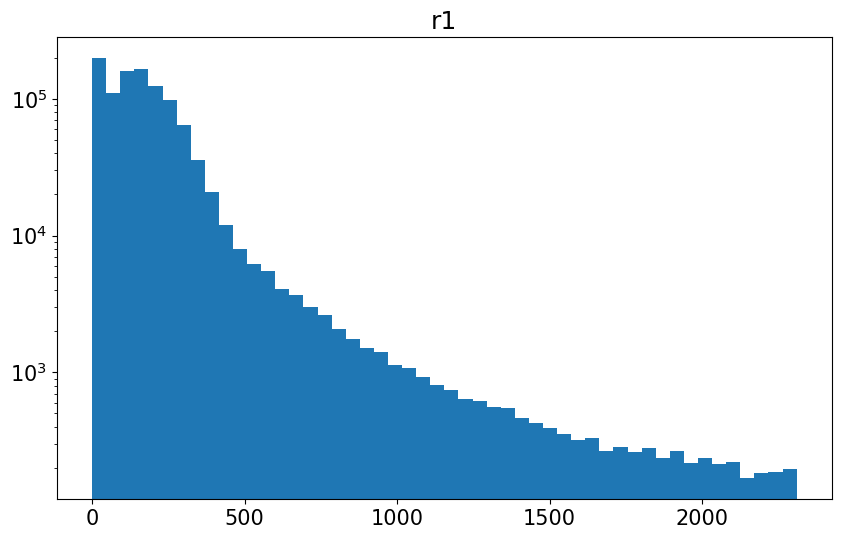

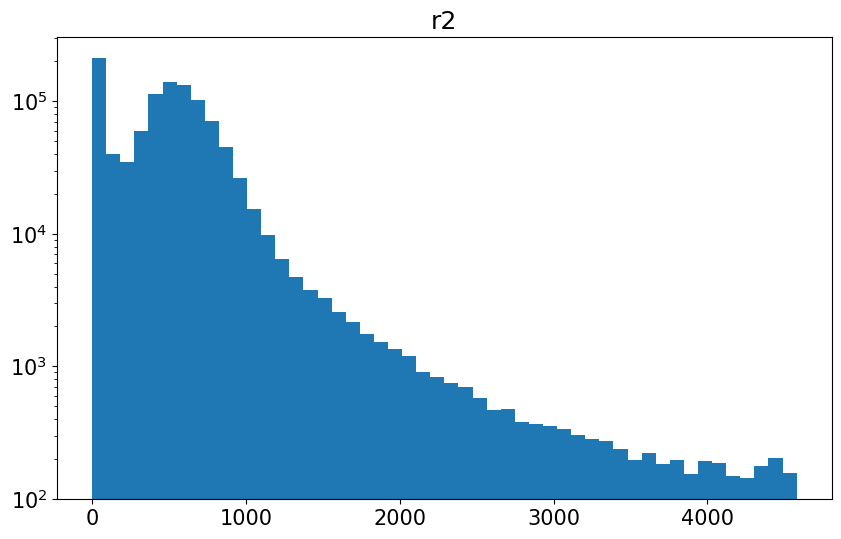

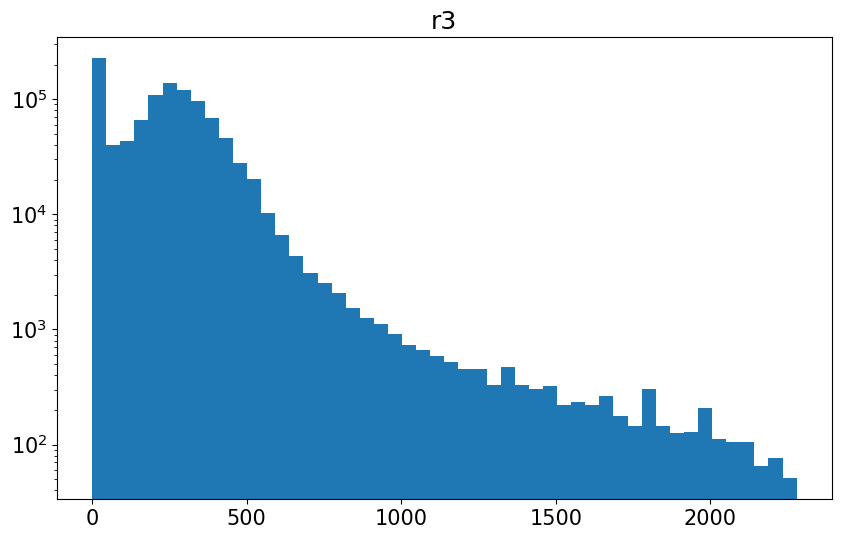

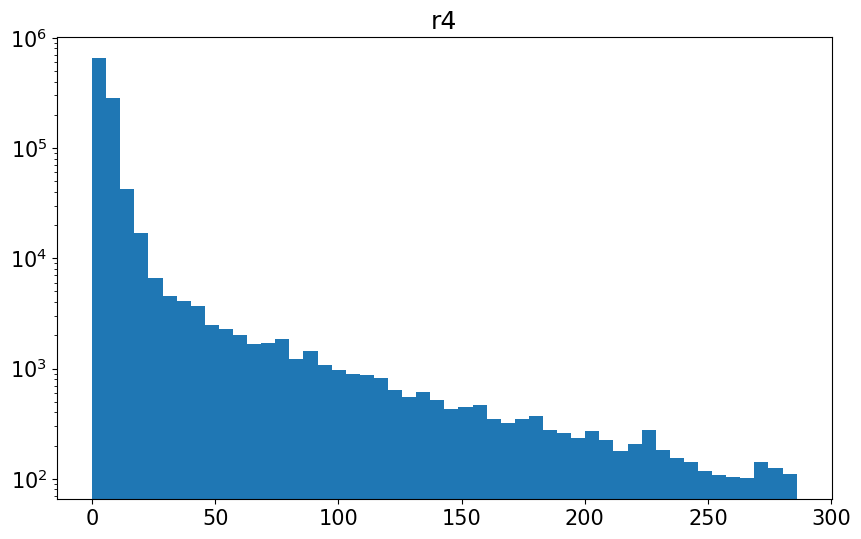

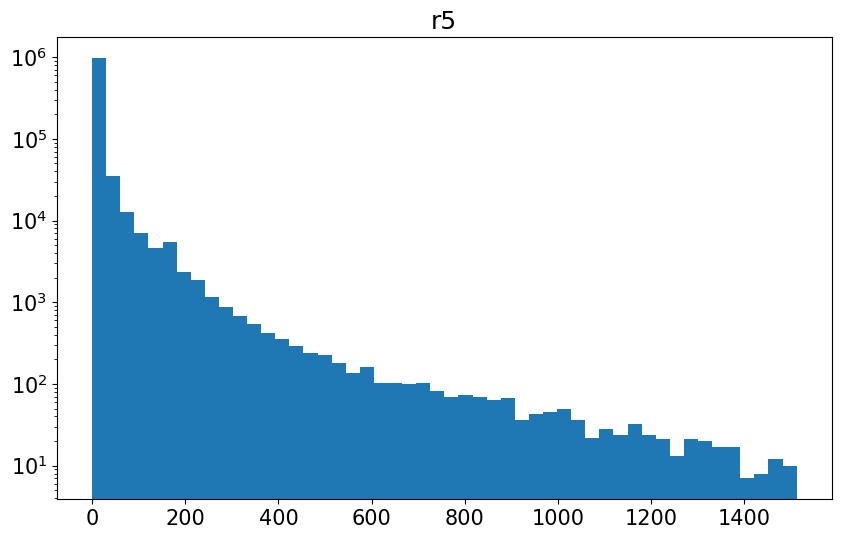

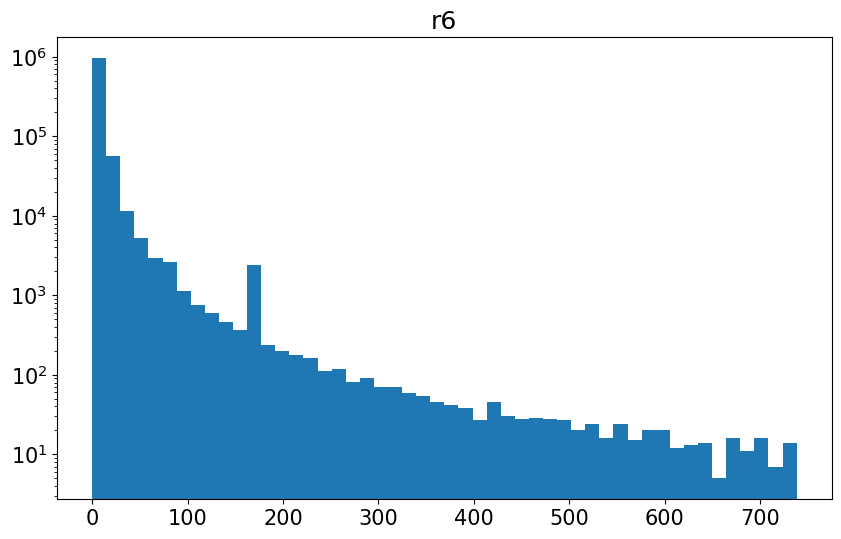

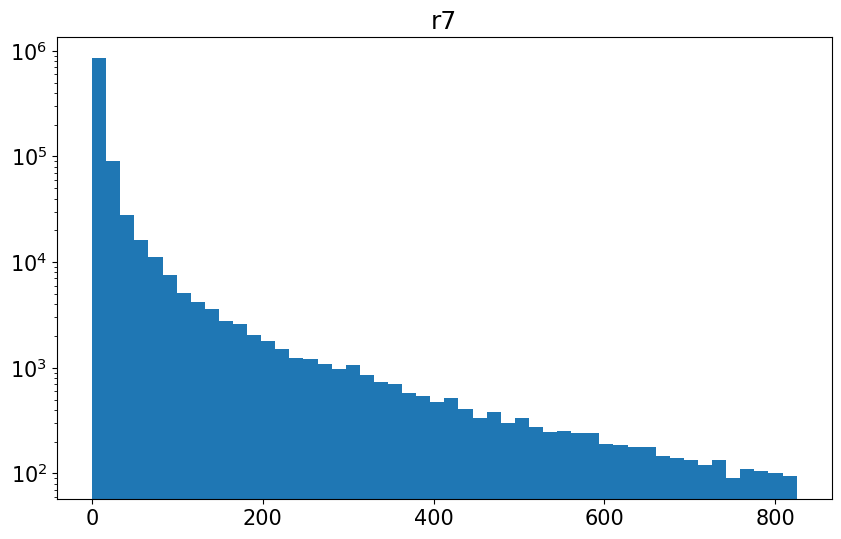

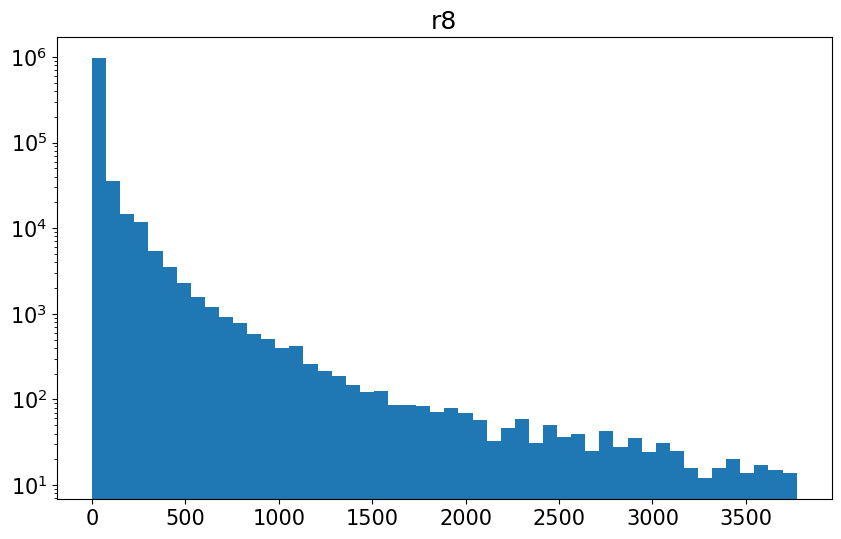

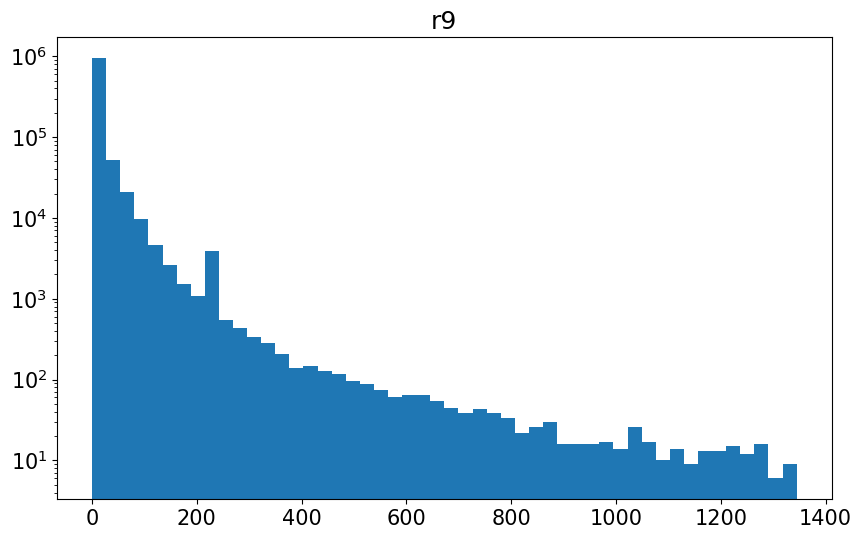

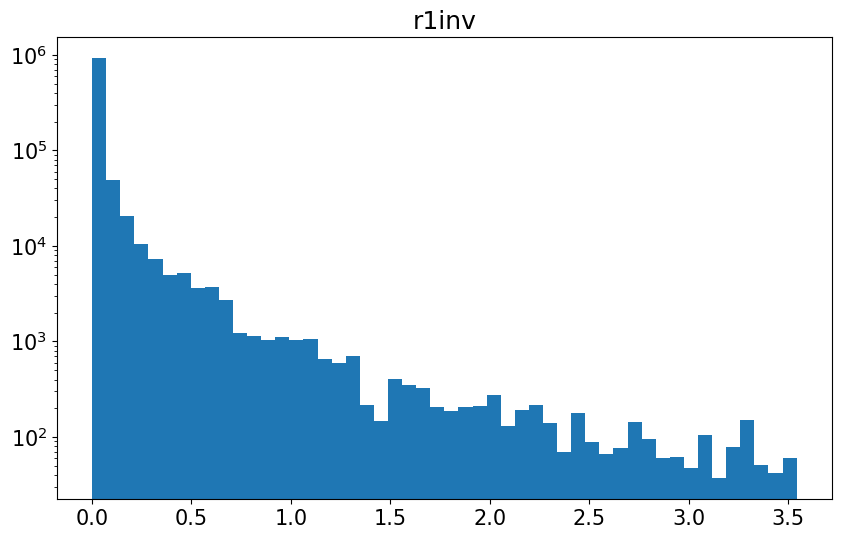

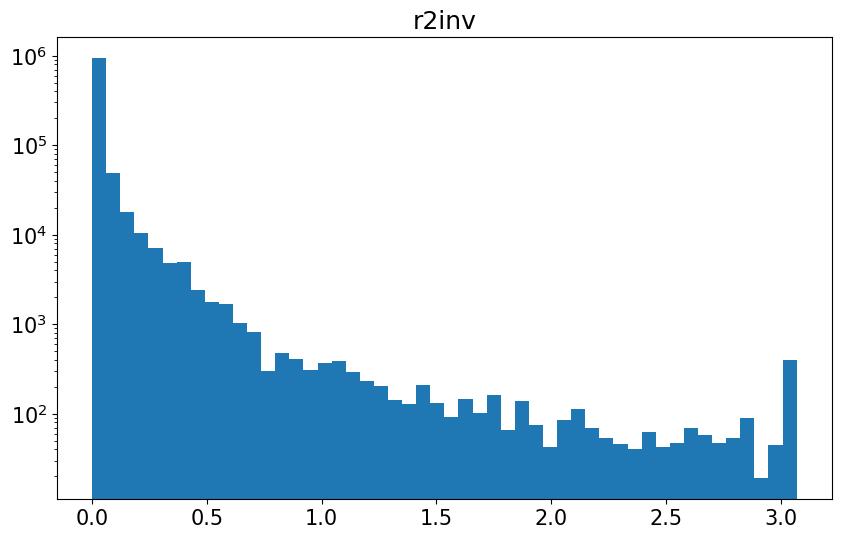

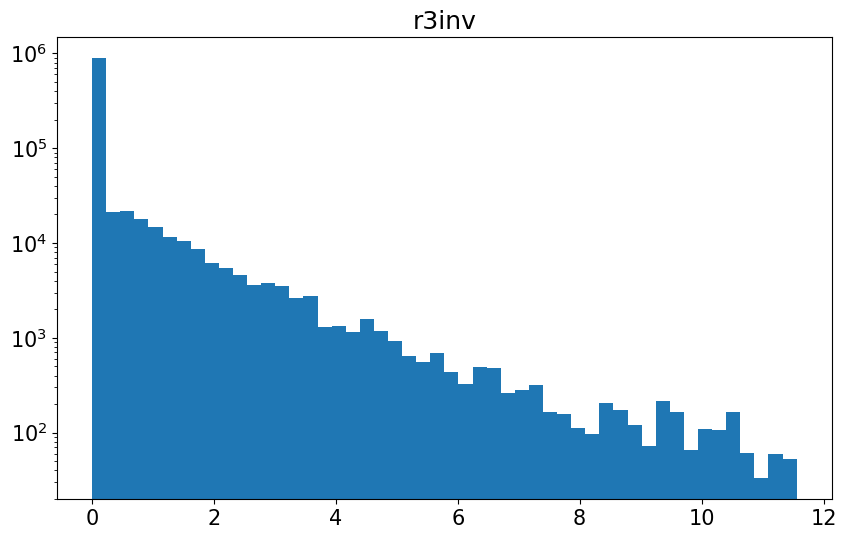

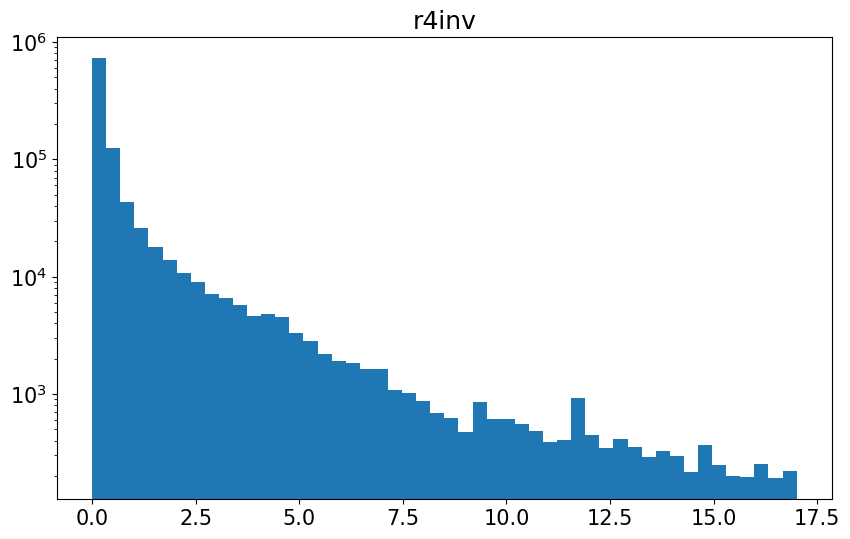

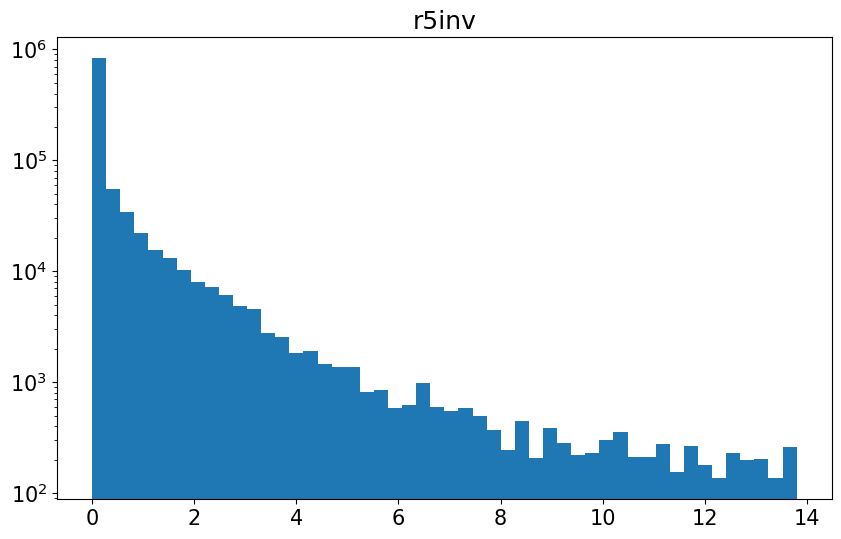

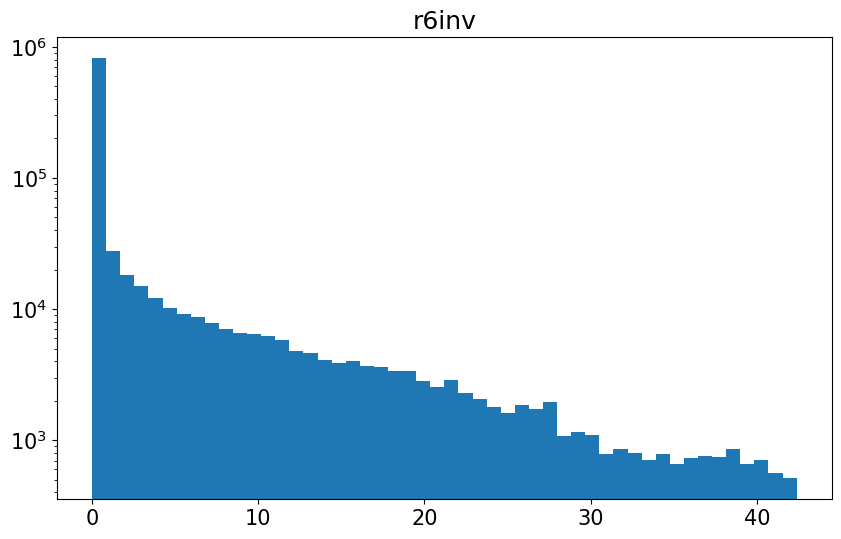

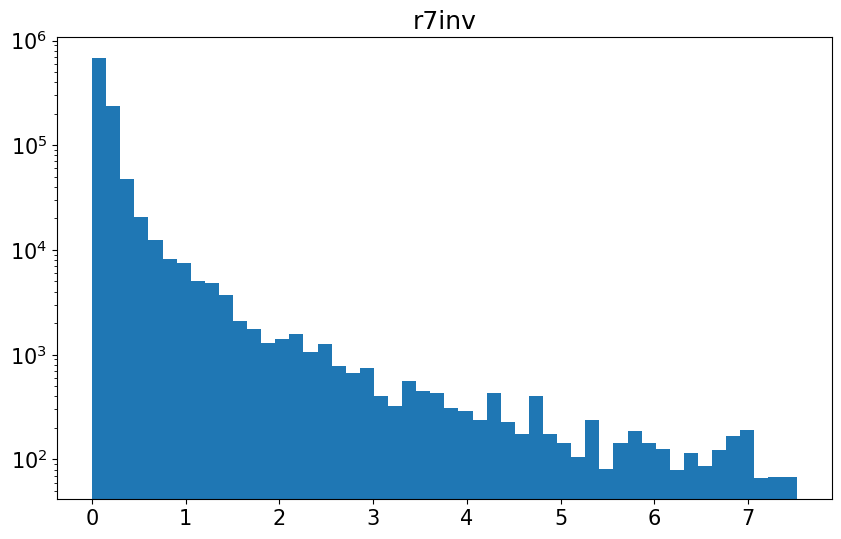

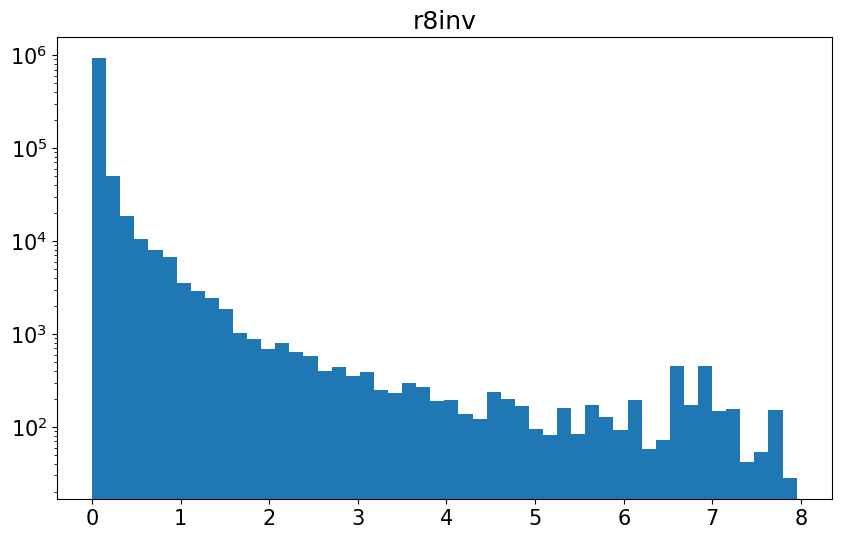

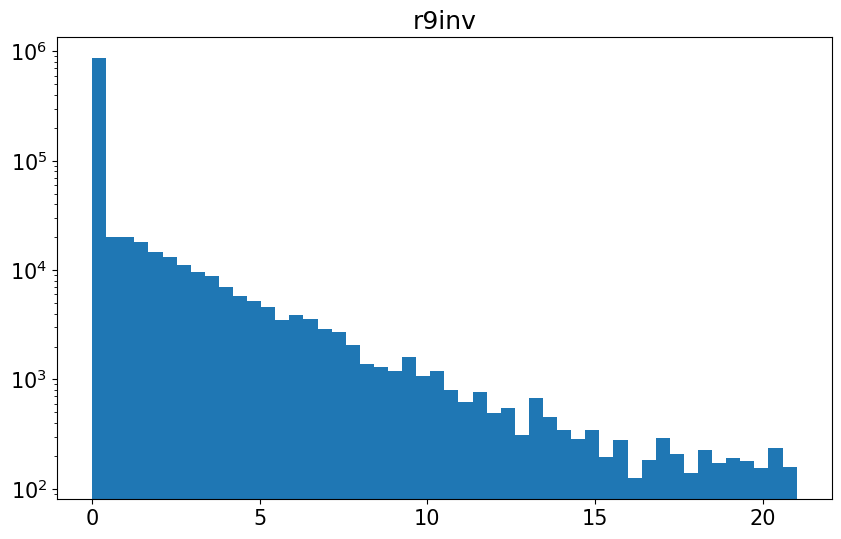

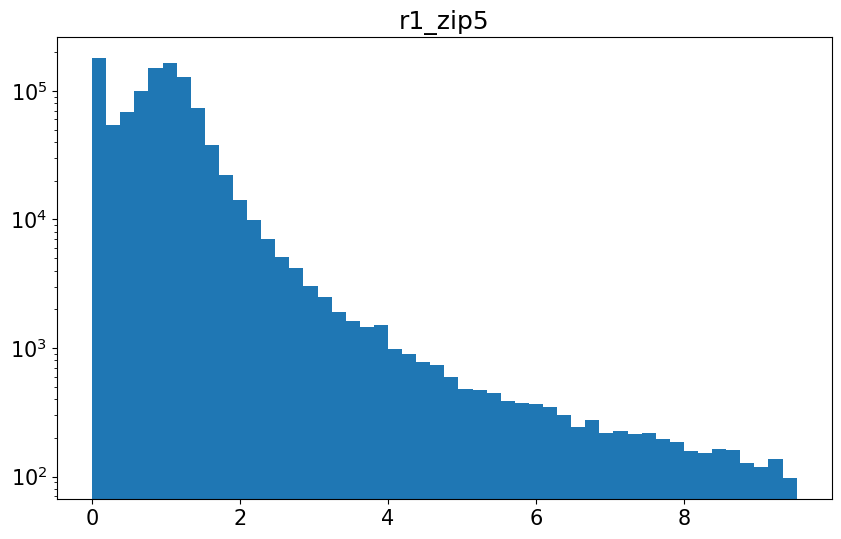

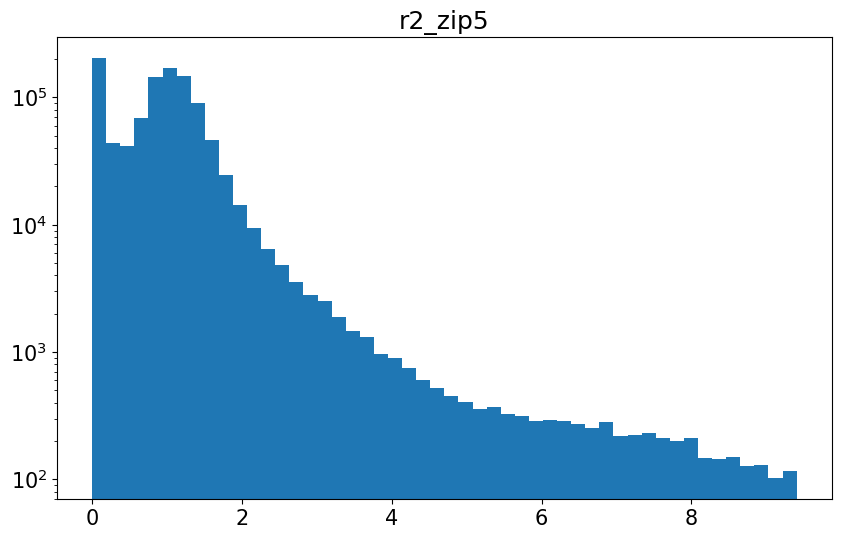

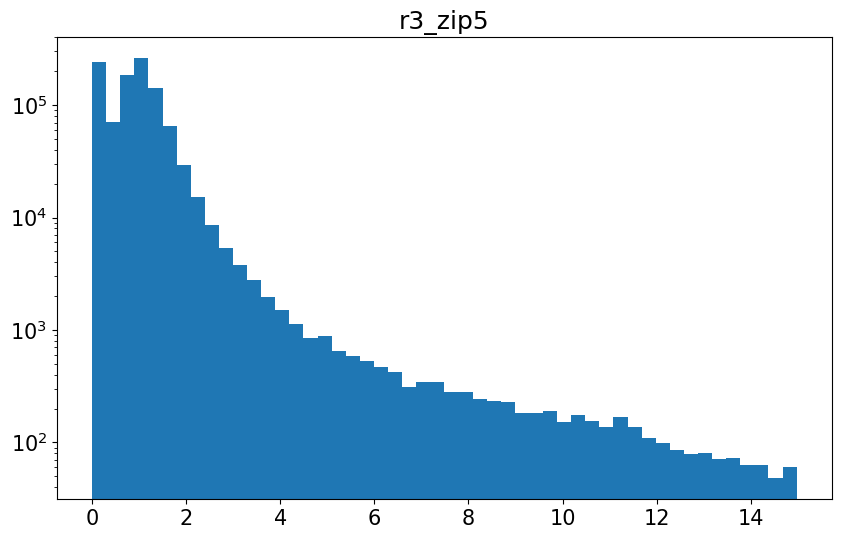

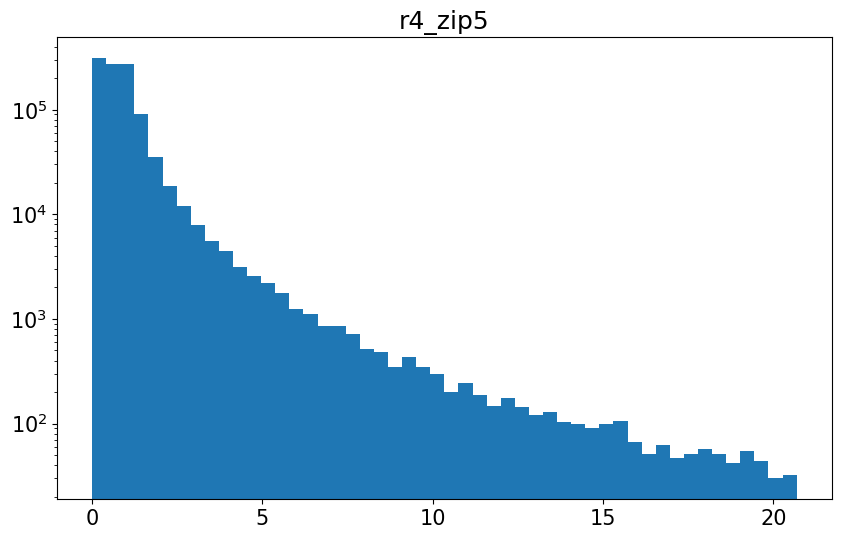

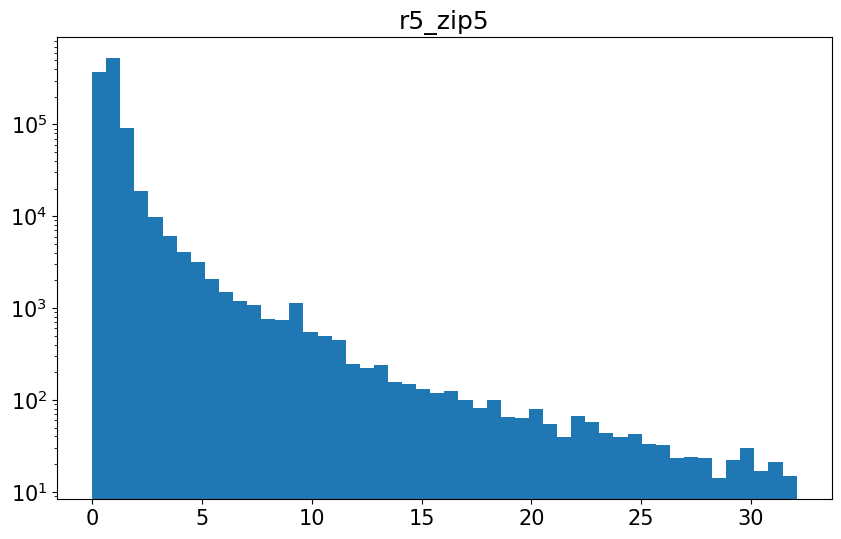

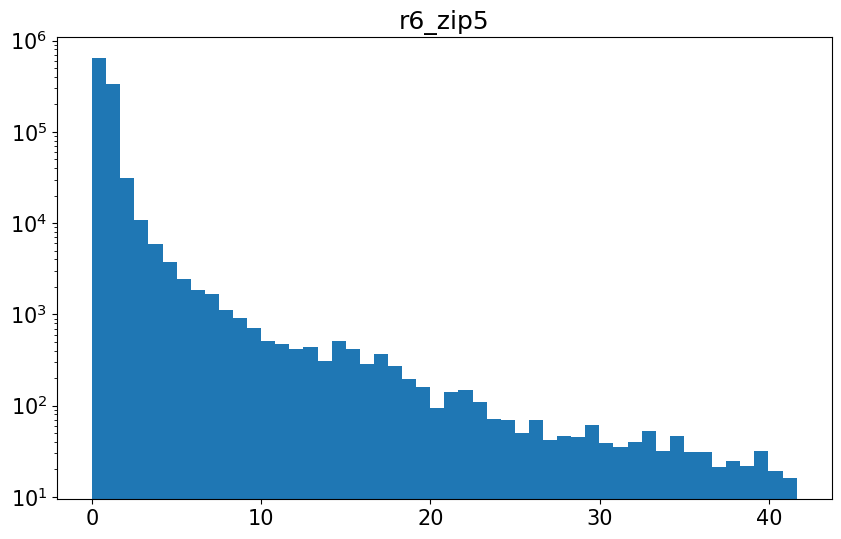

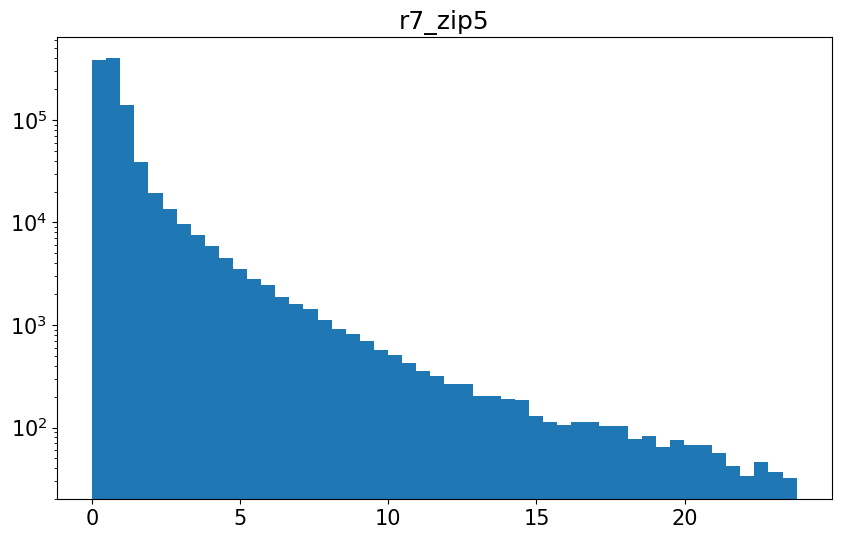

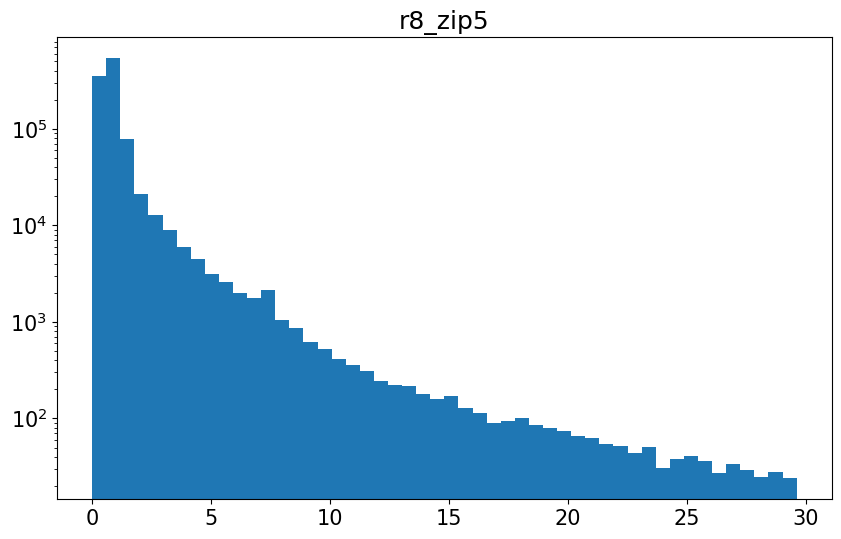

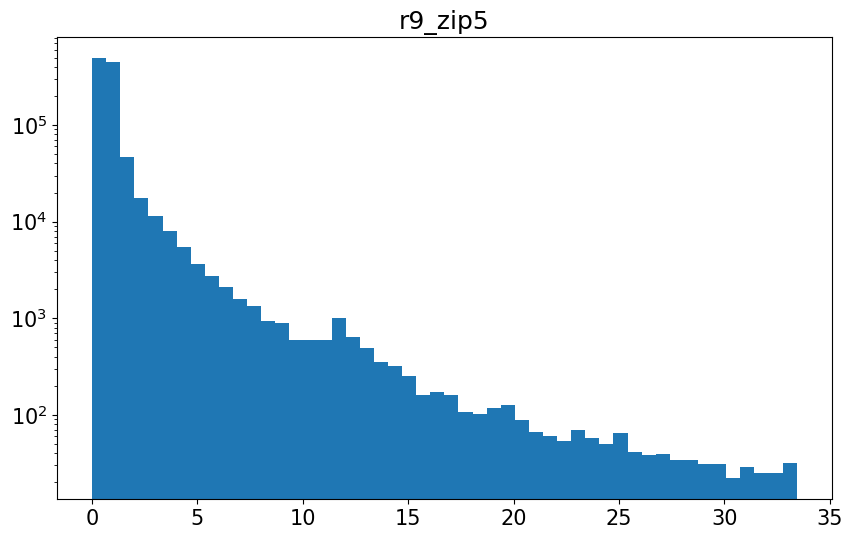

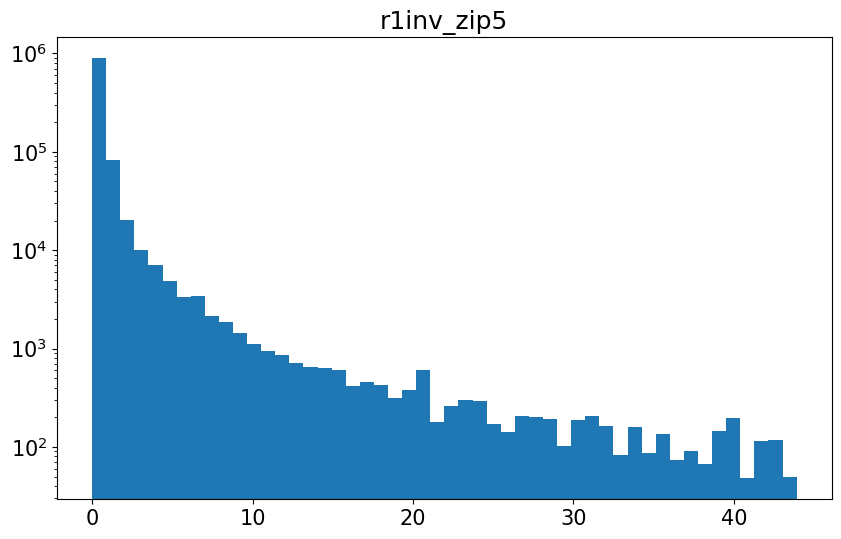

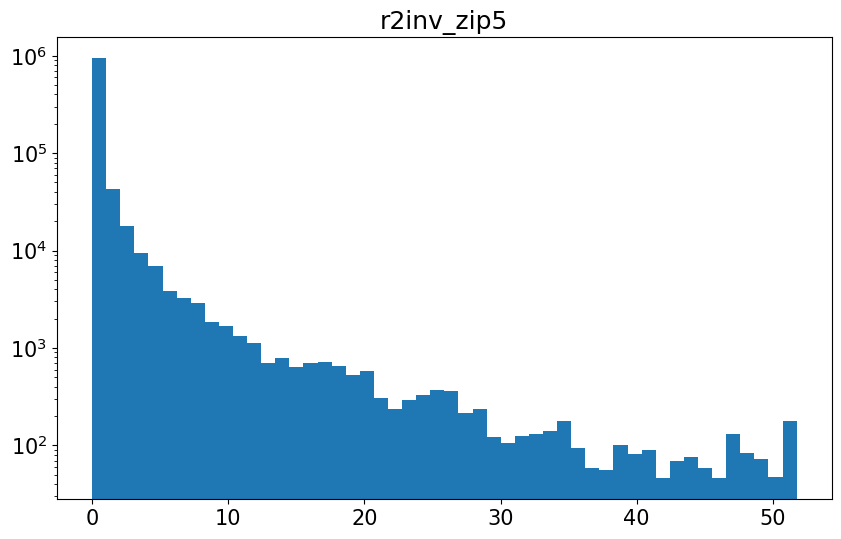

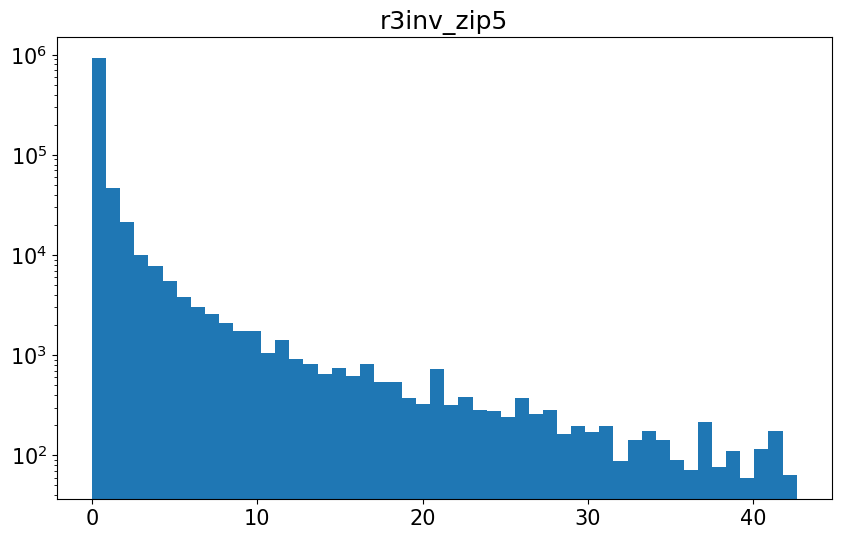

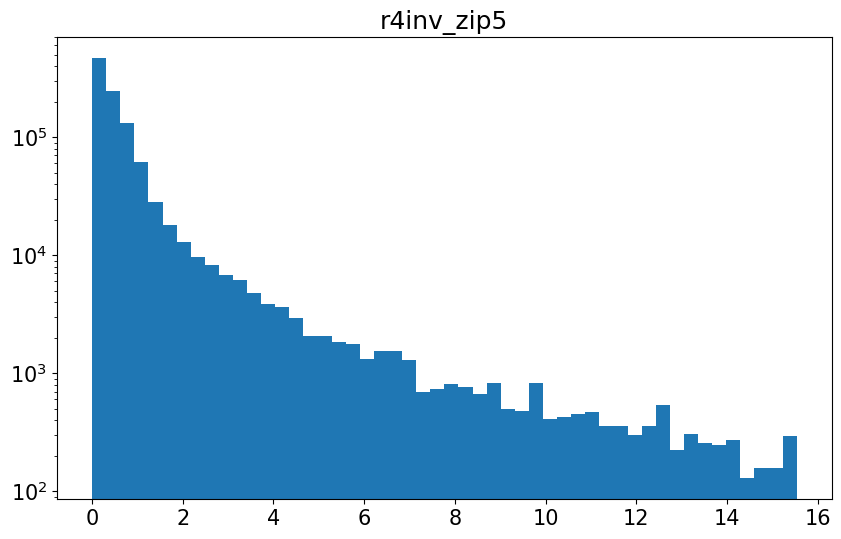

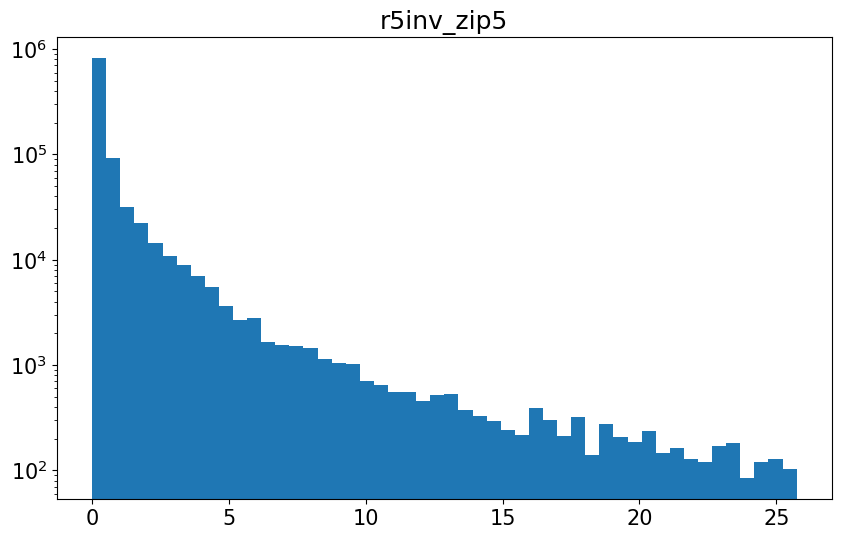

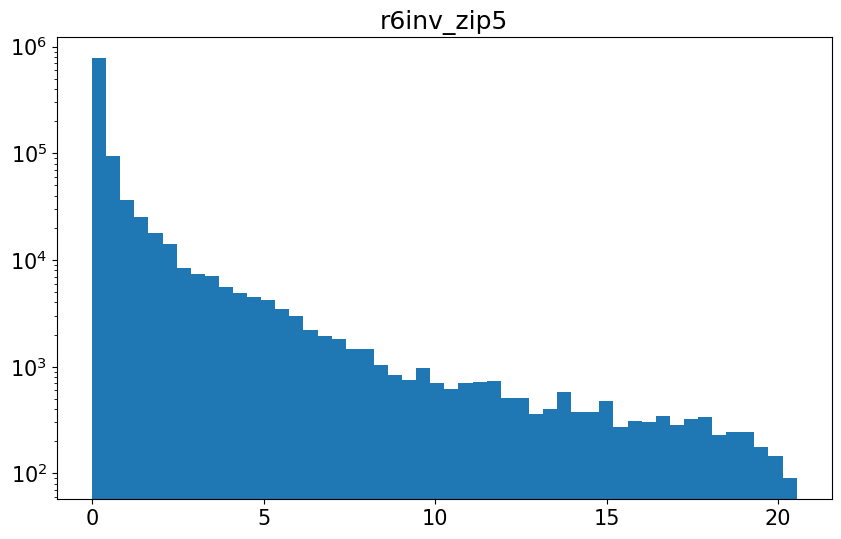

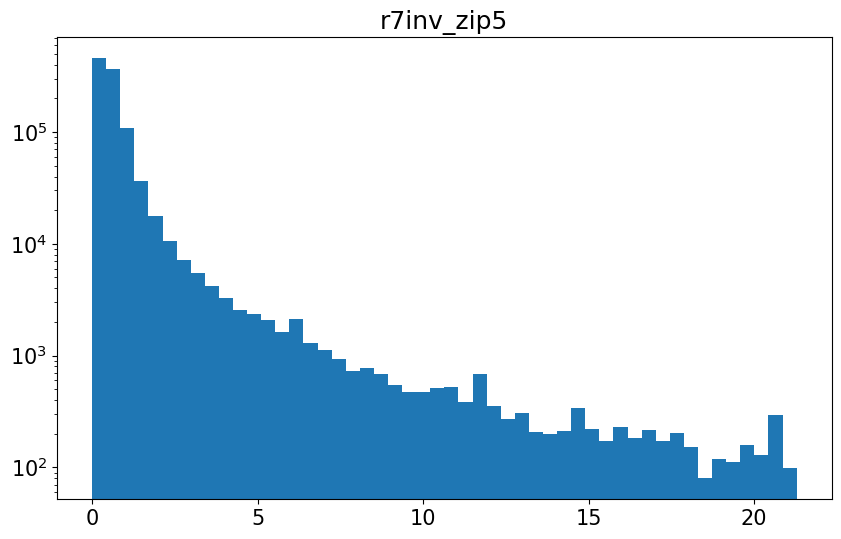

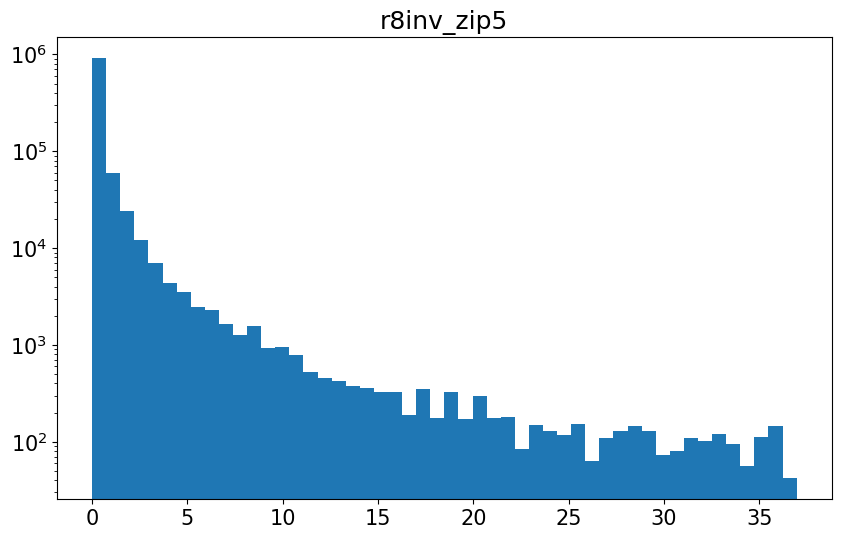

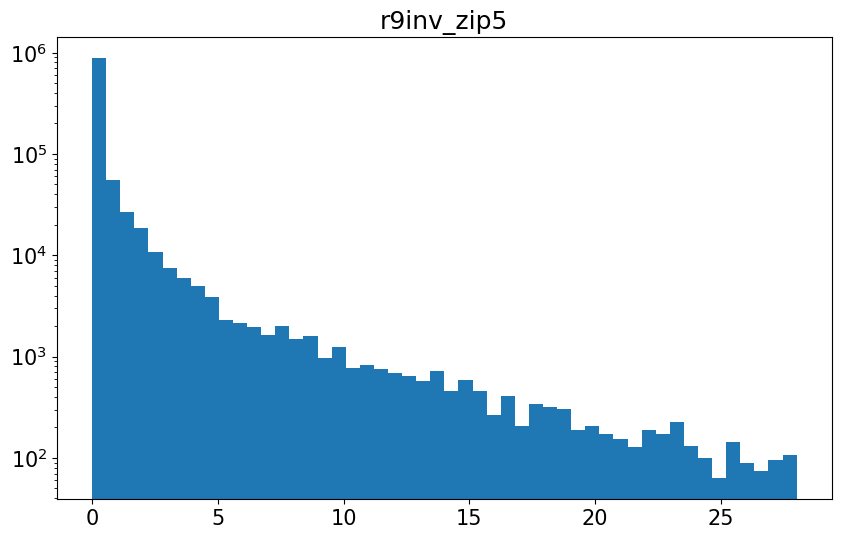

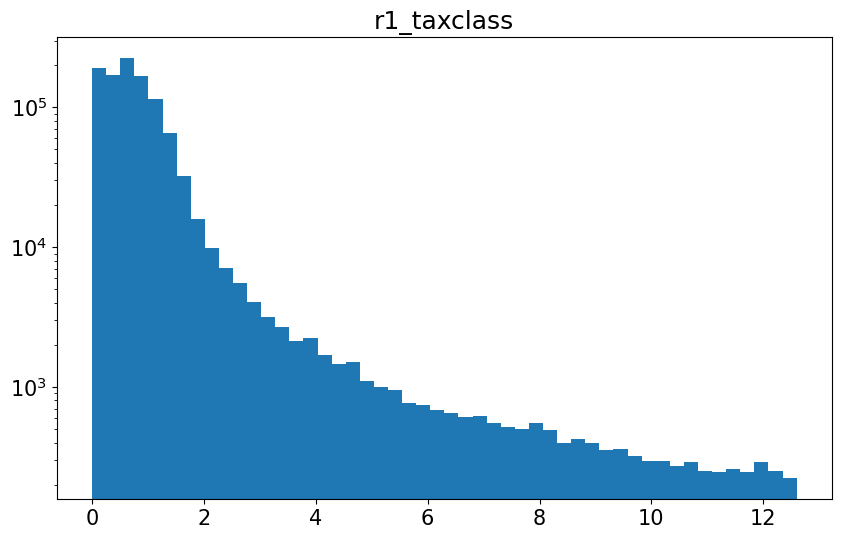

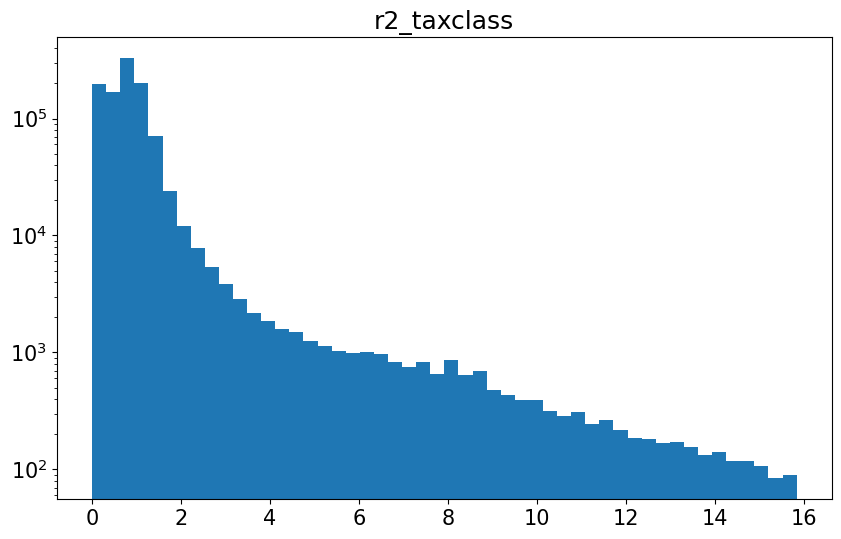

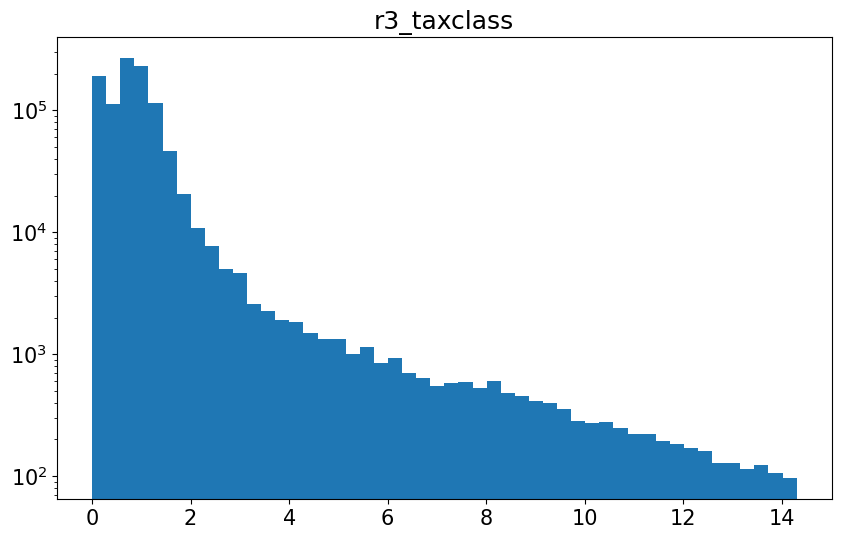

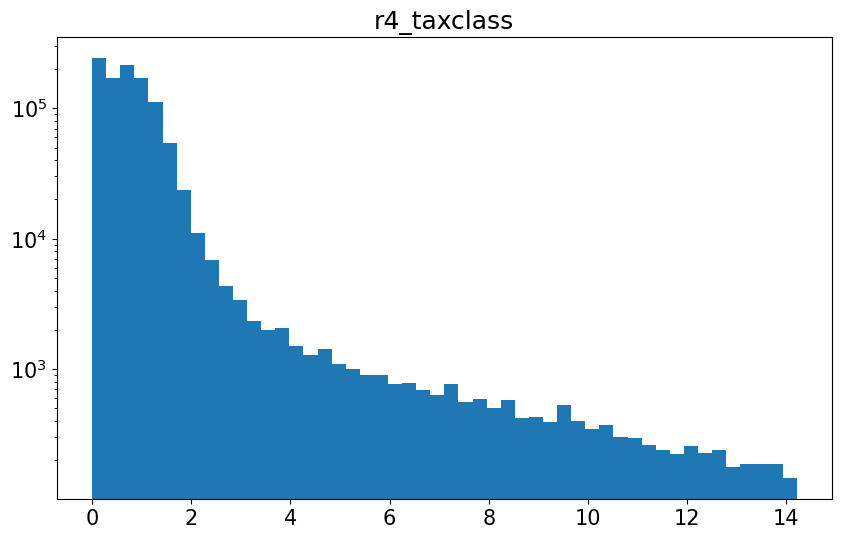

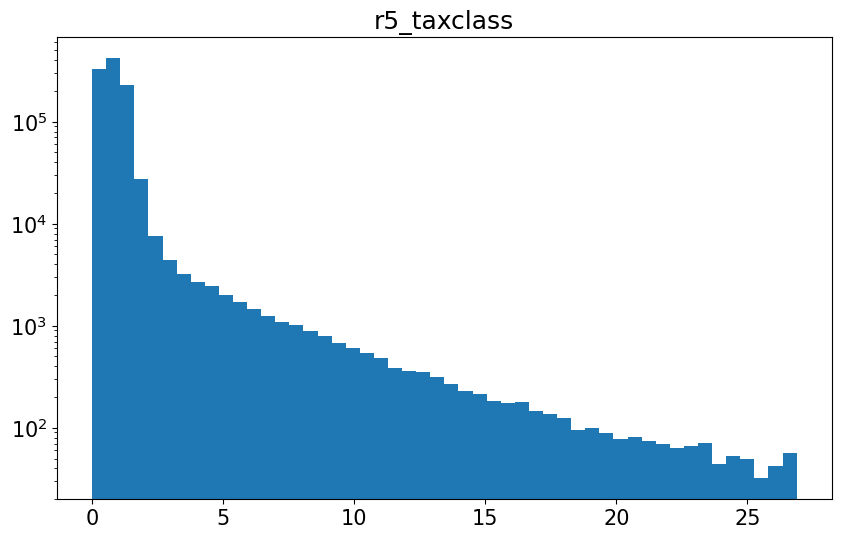

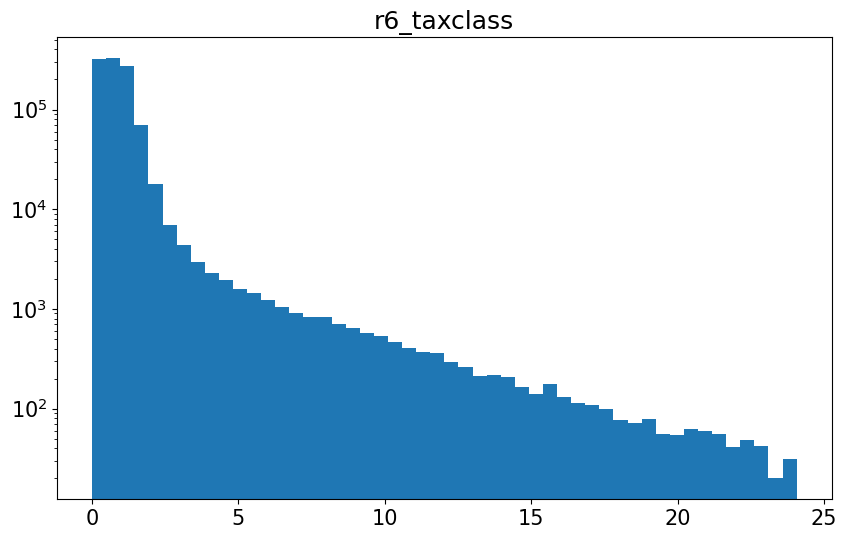

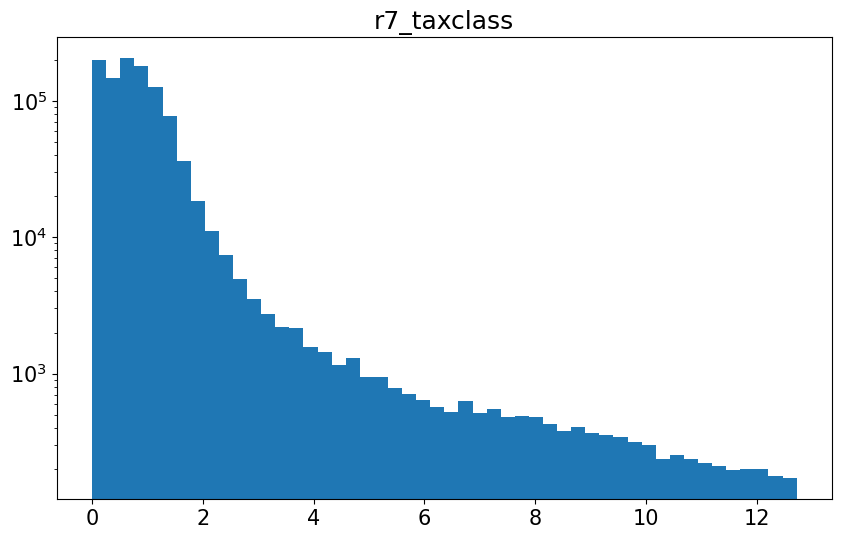

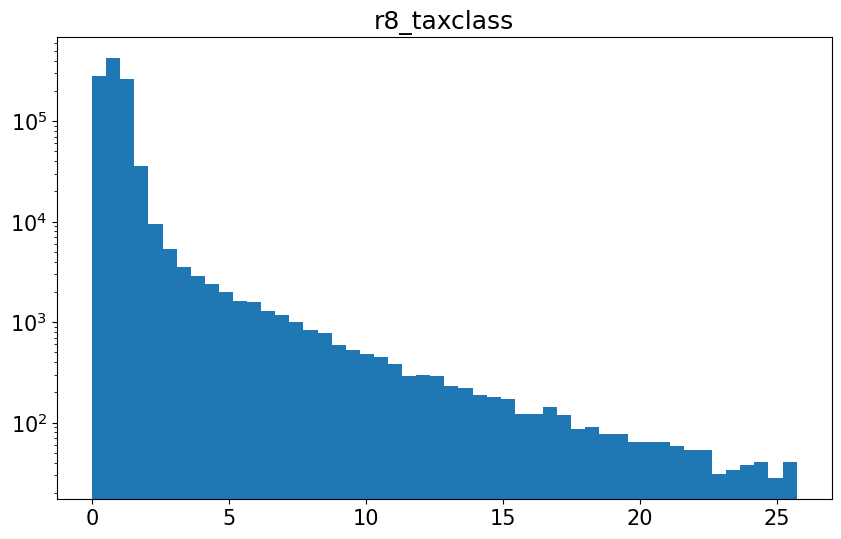

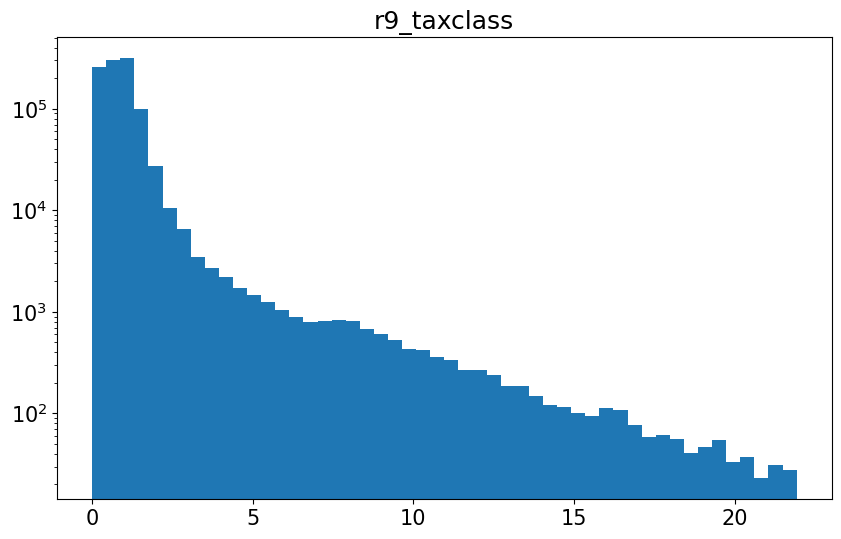

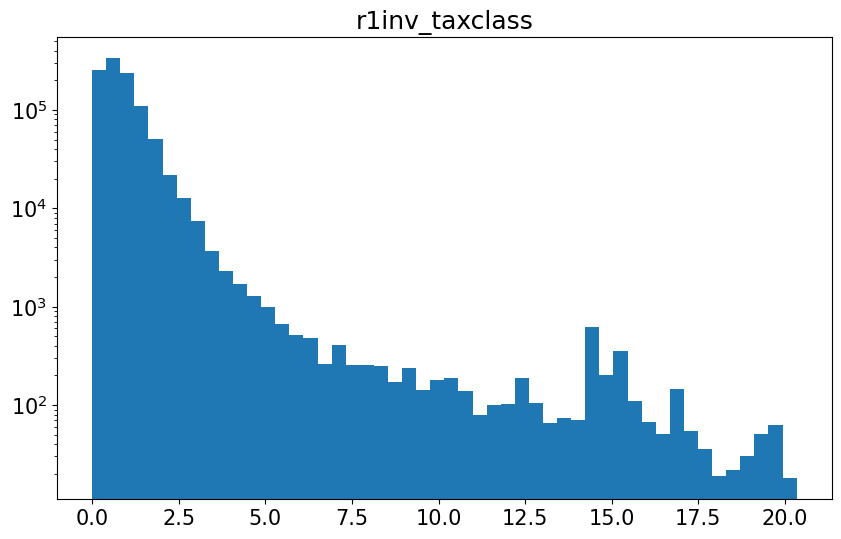

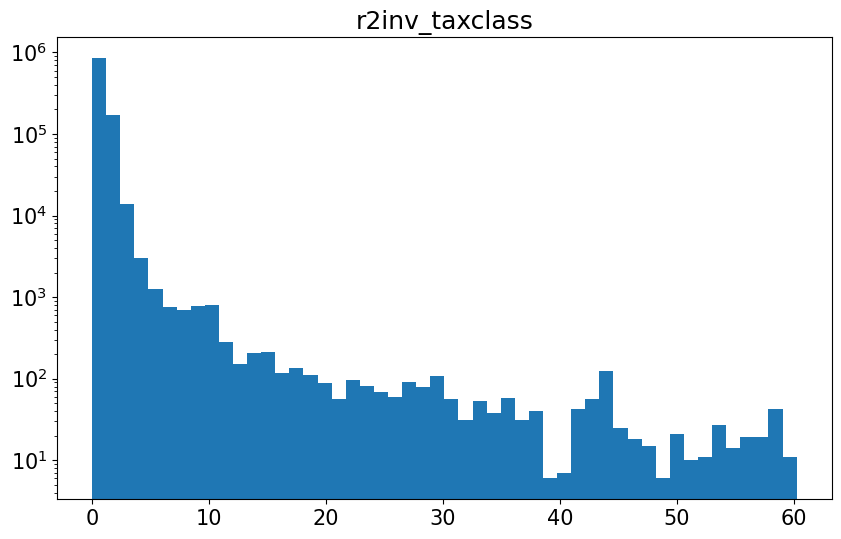

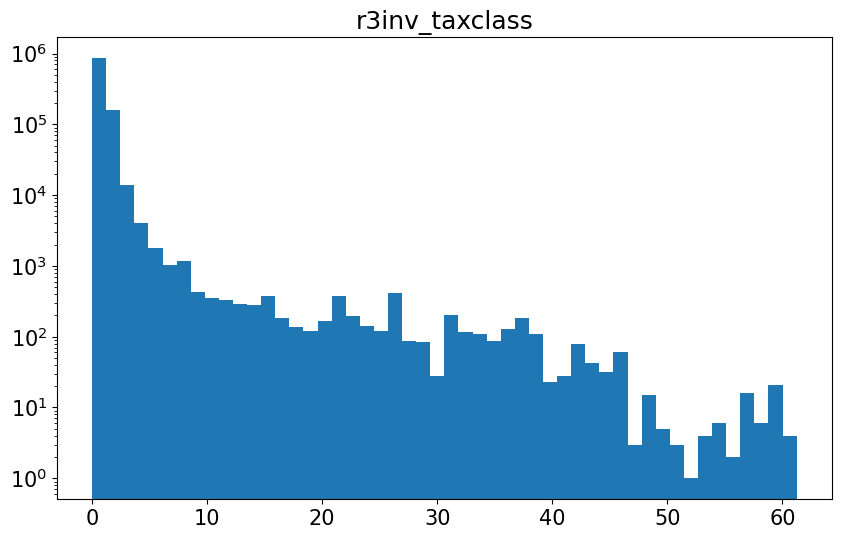

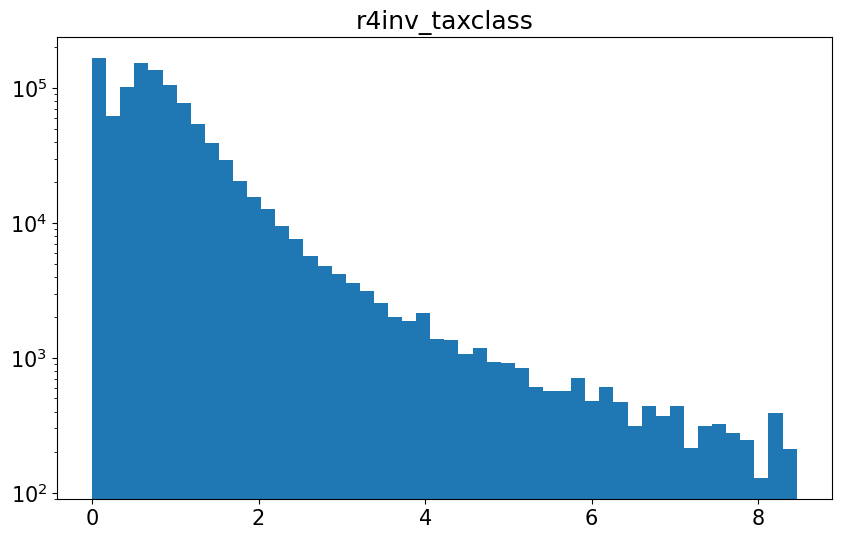

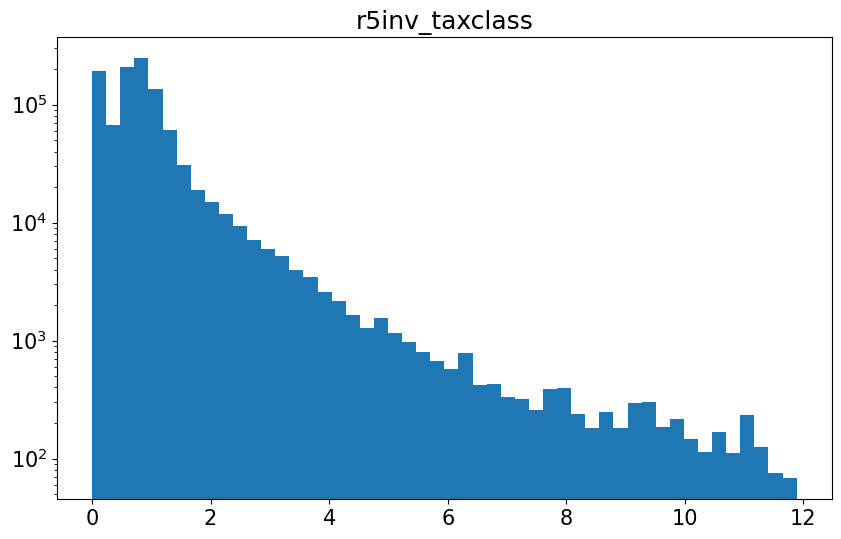

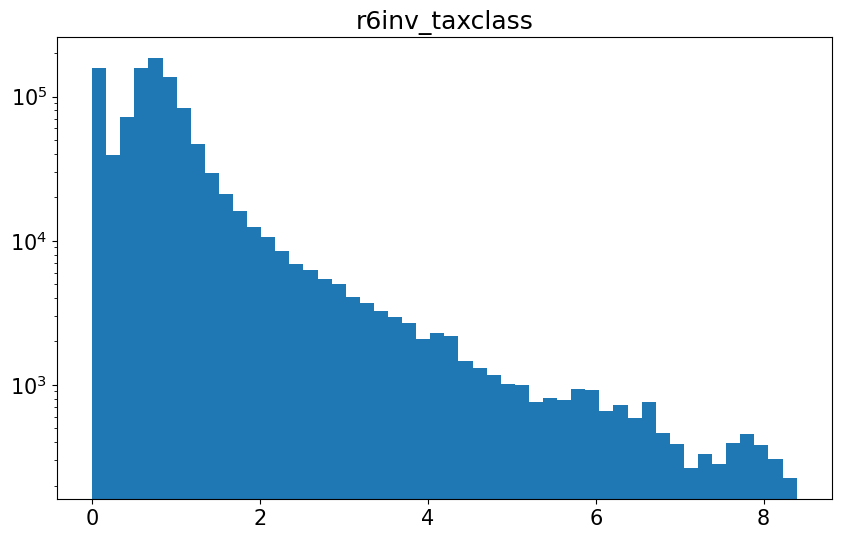

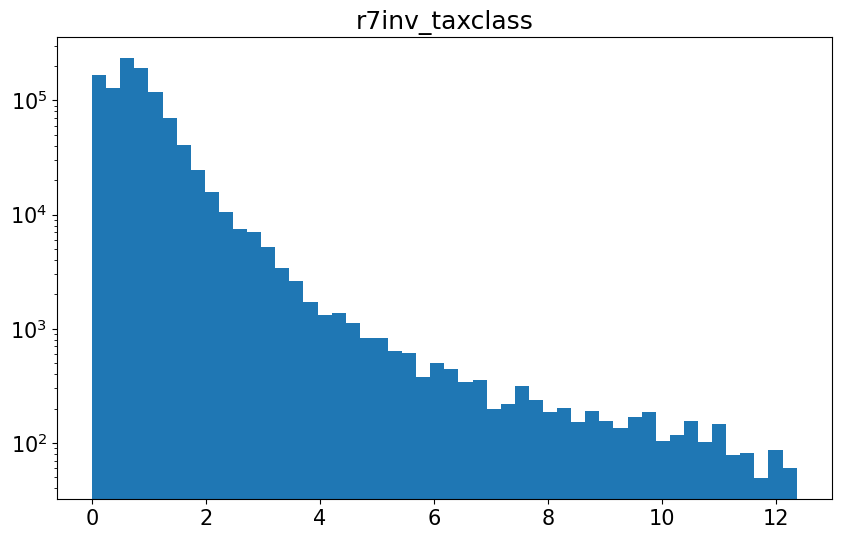

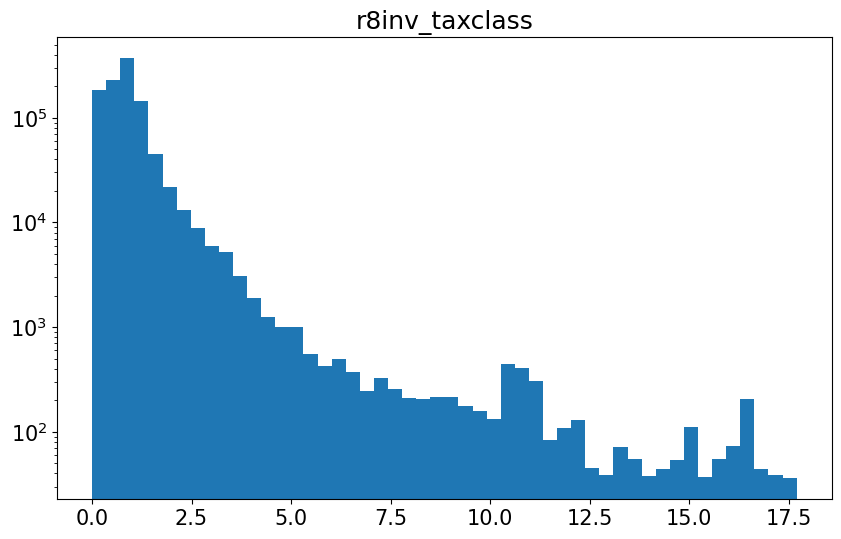

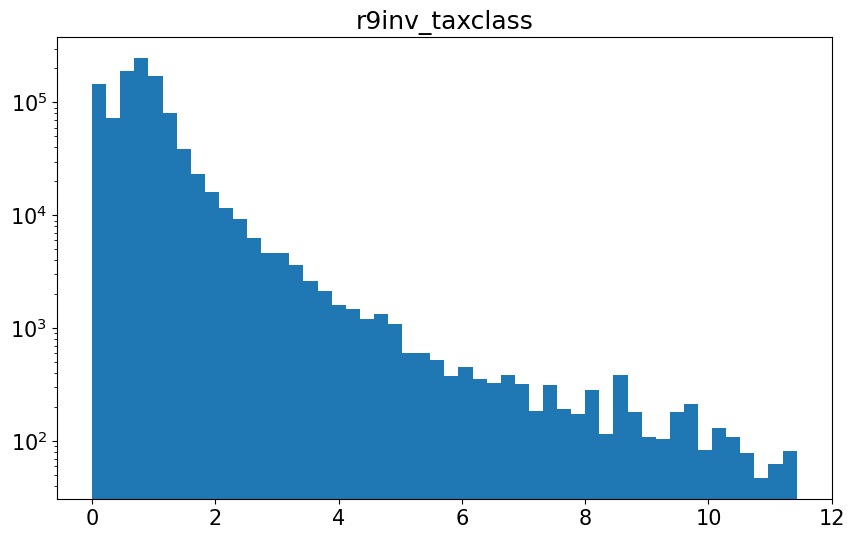

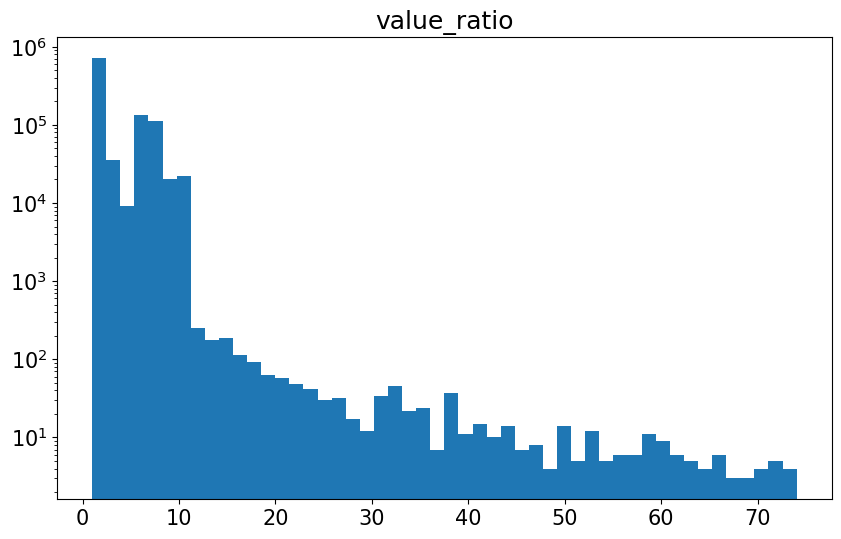

In [55]:
%%time
nstd = 4
for col in data.columns:
    plt.rcParams['figure.figsize'] = [10,6]
    plt.figure()
    plt.rcParams['font.size'] = 15
    plt.yscale('log')
    xstdev = data[col].std()
    xmean = data[col].mean()
    temp = data[data[col] <= xmean + nstd*xstdev]
    temp = temp[data[col] >= xmean - nstd*xstdev]
    plt.hist(temp[col],bins=50)
    plt.title(col)

In [56]:
# data.to_csv('NY vars.csv', index=False)

In [57]:
# zscale all the variables
data_zs = (data - data.mean()) / data.std()
data_zs_save = data_zs.copy()
data_zs.describe()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
count,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,...,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06
mean,-2.339929e-14,-1.594195e-14,-2.156830e-14,-2.653072e-15,-6.097436e-15,1.795510e-16,-4.575118e-14,-7.371118e-16,1.461904e-15,-9.366473e-15,...,-2.063039e-14,2.498357e-15,-9.491561e-16,2.116507e-14,-1.409309e-15,-3.696575e-14,6.289309e-14,4.656286e-15,6.424222e-14,-2.237414e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.071266e-01,-5.300006e-01,-4.833031e-01,-1.510809e-01,-6.063420e-02,-5.827074e-02,-1.336914e-01,-5.382635e-02,-5.988039e-02,-9.401693e-02,...,-2.066794e-01,-6.732825e-02,-6.630364e-02,-5.361123e-01,-3.670310e-01,-5.410942e-01,-3.519283e-01,-2.385486e-01,-3.825671e-01,-1.181670e-01
25%,-2.612012e-01,-3.196744e-01,-3.156636e-01,-1.168730e-01,-4.395833e-02,-4.588664e-02,-1.072131e-01,-3.505878e-02,-3.742962e-02,-8.928042e-02,...,-1.203002e-01,-3.269457e-02,-3.232222e-02,-3.169615e-01,-1.909680e-01,-2.752098e-01,-1.937079e-01,-1.061702e-01,-1.786063e-01,-1.113445e-01
50%,-1.152752e-01,-3.427140e-02,-1.217727e-02,-8.435898e-02,-2.043796e-02,-1.856253e-02,-9.071137e-02,-2.487286e-02,-2.136076e-02,-8.648232e-02,...,-5.633853e-02,-1.222912e-02,-1.309165e-02,-1.499302e-01,-8.974524e-02,-1.330045e-01,-9.354104e-02,-4.974736e-02,-8.047248e-02,-1.023224e-01
75%,5.683724e-02,1.461543e-01,1.787061e-01,-4.626980e-02,-6.219917e-03,-2.638445e-03,-6.598889e-02,-1.518955e-02,-6.530107e-03,-7.894015e-02,...,2.607675e-02,6.762228e-03,6.700815e-03,7.178700e-02,1.914236e-02,3.589633e-02,3.598735e-02,1.455754e-02,2.879739e-02,1.641188e-01
max,2.570905e+02,3.073092e+02,4.464497e+02,3.168146e+02,9.003786e+02,6.149475e+02,3.159333e+02,9.379002e+02,8.791988e+02,1.109388e+02,...,4.098113e+02,7.621465e+02,7.744160e+02,1.908531e+02,4.414974e+02,3.454784e+02,2.130557e+02,4.723137e+02,4.189063e+02,5.614033e+02


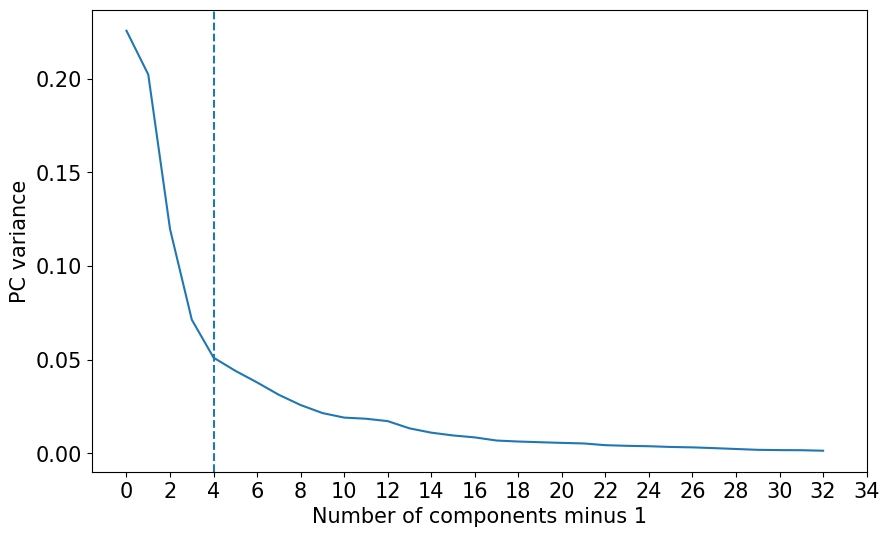

In [58]:
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')

(0.0, 1.0)

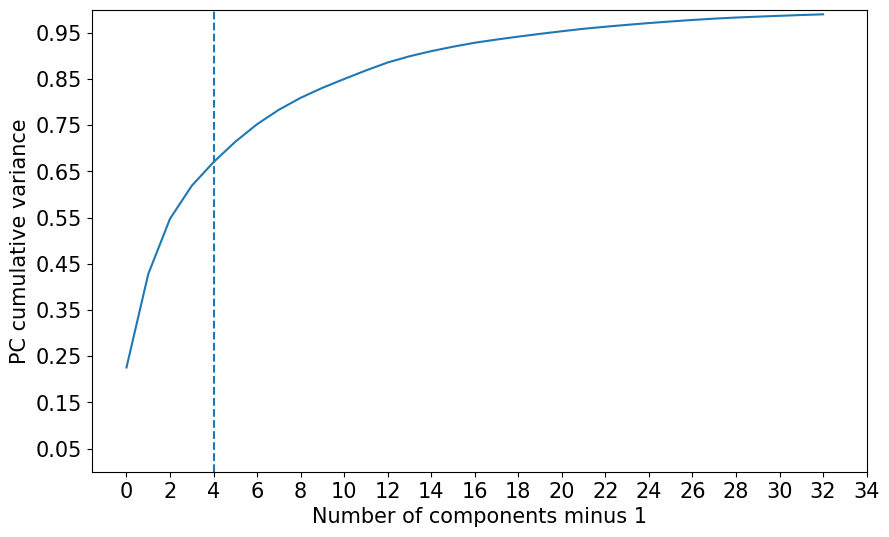

In [59]:
plt.xlabel('Number of components minus 1')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel('PC cumulative variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=4, linestyle='--')
plt.ylim(0,1)

In [60]:
%%time
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components =5, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

Wall time: 1.97 s


5

In [61]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.22560887 0.42784413 0.54762834 0.61903525 0.67017194]


In [62]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1045344, 5)

In [63]:
data_pca.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.979659,-0.583756,0.760460,-0.370805,0.140849
1,1.466761,-0.245345,1.435997,-0.358379,0.119121
2,2.470636,0.452676,2.835195,-0.308889,0.063957
3,0.095343,-1.075029,-0.361389,-0.360711,0.182718
4,0.516028,-0.884265,0.135817,-0.376885,0.161969


In [64]:
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5
count,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06
mean,-6.591655e-16,-3.591735e-15,6.236573e-15,-1.941152e-15,-5.501538e-16
std,3.522568e+00,3.335107e+00,2.566736e+00,1.981762e+00,1.677056e+00
min,-3.226017e+02,-1.224275e+00,-6.423429e+02,-1.175754e+02,-2.776144e+02
25%,-1.177722e-01,-5.039489e-01,-4.208840e-01,-1.642597e-01,-8.487309e-02
50%,2.814266e-01,-4.040464e-01,-2.037942e-01,4.111990e-02,4.216728e-02
75%,5.336647e-01,-2.360764e-01,3.953893e-02,1.698127e-01,1.367867e-01
max,1.534739e+03,1.520033e+03,7.653581e+02,1.109397e+03,5.274658e+02


In [65]:
# # zscale the pcs. This is an optional step, and I like to make all the retained PCs equally important.
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca_zs.describe()
# data_pca_zs = data_pca

,PC1,PC2,PC3,PC4,PC5
count,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06
mean,-4.676995e-16,1.124769e-15,-5.151487e-16,5.611842e-16,6.406215e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.158138e+01,-3.670871e-01,-2.502567e+02,-5.932874e+01,-1.655367e+02
25%,-3.343360e-02,-1.511043e-01,-1.639764e-01,-8.288568e-02,-5.060837e-02
50%,7.989244e-02,-1.211495e-01,-7.939821e-02,2.074916e-02,2.514363e-02
75%,1.514987e-01,-7.078526e-02,1.540436e-02,8.568775e-02,8.156357e-02
max,4.356876e+02,4.557672e+02,2.981835e+02,5.598032e+02,3.145189e+02


In [66]:
data_pca_zs.shape

(1045344, 5)

In [67]:
data_pca_zs.head(5)

,PC1,PC2,PC3,PC4,PC5
0,0.278109,-0.175034,0.296275,-0.187109,0.083986
1,0.416390,-0.073564,0.559464,-0.180838,0.071030
2,0.701374,0.135731,1.104592,-0.155866,0.038136
3,0.027066,-0.322337,-0.140797,-0.182015,0.108952
4,0.146492,-0.265138,0.052914,-0.190177,0.096580


## Now calculate two unsupervised fraud scores

In [68]:
# Set the powers for the two Minkowski distances. The final results are relatively insensitive to these choices. 
# Good choices are anywhere from 1 to about 4.
p1 = 2
p2 = 2
ntop = 10000

### Calculate score 1

In [69]:
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1.head(10)

0    0.487672
1    0.727695
2    1.325224
3    0.411652
4    0.374237
5    0.373021
6    1.054269
7    1.020020
8    1.020020
9    1.020020
dtype: float64

In [70]:
data_pca_zs.head(10)

,PC1,PC2,PC3,PC4,PC5
0,0.278109,-0.175034,0.296275,-0.187109,0.083986
1,0.416390,-0.073564,0.559464,-0.180838,0.071030
2,0.701374,0.135731,1.104592,-0.155866,0.038136
3,0.027066,-0.322337,-0.140797,-0.182015,0.108952
4,0.146492,-0.265138,0.052914,-0.190177,0.096580
5,0.135888,-0.271739,0.034035,-0.190129,0.097620
6,0.574730,0.045342,0.863832,-0.172439,0.056306
7,0.558705,0.033237,0.832950,-0.173320,0.057793
8,0.558705,0.033237,0.832950,-0.173320,0.057793
9,0.558705,0.033237,0.832950,-0.173320,0.057793


In [71]:
score1.max()

679.0567393359555

### Autoencoder for score 2

In [72]:
%%time
#NNmodel = MLPRegressor(hidden_layer_sizes=(100,50,25),activation='logistic',max_iter=50,random_state=1)
NNmodel = MLPRegressor(hidden_layer_sizes=(3),activation='logistic',max_iter=50,random_state=1)
NNmodel.fit(data_pca_zs,data_pca_zs)

Wall time: 24.9 s


C:\Users\micha\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='logistic', hidden_layer_sizes=3, max_iter=50,
             random_state=1)

In [73]:
# calculate score 2 as the error of an autoencoder
pca_out = NNmodel.predict(data_pca_zs)
error = pca_out - data_pca_zs
oop2 = 1/p2
score2 = ((error.abs()**p2).sum(axis=1))**oop2

In [74]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['RECORD'] = save_record
scores.head(10)

,score1,score2,RECORD
0,0.487672,0.214136,9
1,0.727695,0.239940,10
2,1.325224,0.312103,11
3,0.411652,0.190554,12
4,0.374237,0.200933,13
5,0.373021,0.200289,14
6,1.054269,0.279056,15
7,1.020020,0.274831,16
8,1.020020,0.274831,17
9,1.020020,0.274831,18


In [75]:
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank
0,0.487672,0.214136,9,851395.0,809542.0
1,0.727695,0.239940,10,931285.0,867529.0
2,1.325224,0.312103,11,990313.0,931443.0
3,0.411652,0.190554,12,740413.0,733712.0
4,0.374237,0.200933,13,647905.0,766125.0
5,0.373021,0.200289,14,645826.0,764007.0
6,1.054269,0.279056,15,973689.0,909785.0
7,1.020020,0.274831,16,970857.0,906151.0
8,1.020020,0.274831,17,970860.0,906145.0
9,1.020020,0.274831,18,970862.0,906149.0


In [76]:
# calculate the final score as the average of the two scores
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
scores_sorted = scores.sort_values(by='final', ascending=False)
scores.head(20)

,score1,score2,RECORD,score1 rank,score2 rank,final
0,0.487672,0.214136,9,851395.0,809542.0,830468.5
1,0.727695,0.239940,10,931285.0,867529.0,899407.0
2,1.325224,0.312103,11,990313.0,931443.0,960878.0
3,0.411652,0.190554,12,740413.0,733712.0,737062.5
4,0.374237,0.200933,13,647905.0,766125.0,707015.0
5,0.373021,0.200289,14,645826.0,764007.0,704916.5
6,1.054269,0.279056,15,973689.0,909785.0,941737.0
7,1.020020,0.274831,16,970857.0,906151.0,938504.0
8,1.020020,0.274831,17,970860.0,906145.0,938502.5
9,1.020020,0.274831,18,970862.0,906149.0,938505.5


In [77]:
scores_sorted.head(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
897701,679.056739,671.548477,917942,1045344.0,1045344.0,1045344.0
934896,657.488083,656.213741,956520,1045343.0,1045343.0,1045343.0
641223,564.314895,562.991520,658933,1045342.0,1045342.0,1045342.0
1034942,306.577031,281.974595,1059883,1045341.0,1045341.0,1045341.0
647427,228.250914,222.441896,665158,1045339.0,1045340.0,1045339.5
137254,238.842938,214.361966,139726,1045340.0,1045338.0,1045339.0
320403,221.254770,220.569319,333412,1045337.0,1045339.0,1045338.0
114983,227.099000,202.515742,116647,1045338.0,1045337.0,1045337.5
666866,213.074325,188.764838,684704,1045336.0,1045336.0,1045336.0
368211,187.177849,180.982474,382398,1045335.0,1045335.0,1045335.0


In [78]:
scores_sorted.tail(10)

,score1,score2,RECORD,score1 rank,score2 rank,final
411082,0.123714,0.013811,426737,132.0,105.0,118.5
822570,0.128450,0.012985,841688,190.0,46.0,118.0
819929,0.130561,0.012227,839038,217.5,17.5,117.5
819925,0.130561,0.012227,839034,217.5,17.5,117.5
819923,0.130561,0.012227,839032,217.5,17.5,117.5
819922,0.130561,0.012227,839031,217.5,17.5,117.5
764578,0.129024,0.012847,783170,196.0,38.0,117.0
821988,0.128529,0.009387,841104,191.0,1.0,96.0
824407,0.126191,0.010661,843527,169.0,4.0,86.5
821984,0.126073,0.011220,841100,168.0,5.0,86.5


In [79]:
scores.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06
mean,5.664578e-01,2.131832e-01,5.371474e+05,5.226725e+05,5.226725e+05,5.226725e+05
std,2.163129e+00,1.545784e+00,3.080402e+05,3.017650e+05,3.017650e+05,2.878011e+05
min,4.618313e-02,9.387246e-03,9.000000e+00,1.000000e+00,1.000000e+00,8.650000e+01
25%,2.191024e-01,6.622194e-02,2.732568e+05,2.613310e+05,2.613365e+05,2.715940e+05
50%,2.813714e-01,1.175421e-01,5.391535e+05,5.226725e+05,5.226725e+05,5.217132e+05
75%,4.345828e-01,2.060417e-01,8.026742e+05,7.840082e+05,7.840082e+05,7.653100e+05
max,6.790567e+02,6.715485e+02,1.070994e+06,1.045344e+06,1.045344e+06,1.045344e+06


In [80]:
scores_sorted.describe()

,score1,score2,RECORD,score1 rank,score2 rank,final
count,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06,1.045344e+06
mean,5.664578e-01,2.131832e-01,5.371474e+05,5.226725e+05,5.226725e+05,5.226725e+05
std,2.163129e+00,1.545784e+00,3.080402e+05,3.017650e+05,3.017650e+05,2.878011e+05
min,4.618313e-02,9.387246e-03,9.000000e+00,1.000000e+00,1.000000e+00,8.650000e+01
25%,2.191024e-01,6.622194e-02,2.732568e+05,2.613310e+05,2.613365e+05,2.715940e+05
50%,2.813714e-01,1.175421e-01,5.391535e+05,5.226725e+05,5.226725e+05,5.217132e+05
75%,4.345828e-01,2.060417e-01,8.026742e+05,7.840082e+05,7.840082e+05,7.653100e+05
max,6.790567e+02,6.715485e+02,1.070994e+06,1.045344e+06,1.045344e+06,1.045344e+06


In [81]:
scores_sorted.set_index('RECORD', drop=True, inplace=True)
scores_sorted.head(10)

,score1,score2,score1 rank,score2 rank,final
RECORD,,,,,
917942,679.056739,671.548477,1045344.0,1045344.0,1045344.0
956520,657.488083,656.213741,1045343.0,1045343.0,1045343.0
658933,564.314895,562.991520,1045342.0,1045342.0,1045342.0
1059883,306.577031,281.974595,1045341.0,1045341.0,1045341.0
665158,228.250914,222.441896,1045339.0,1045340.0,1045339.5
139726,238.842938,214.361966,1045340.0,1045338.0,1045339.0
333412,221.254770,220.569319,1045337.0,1045339.0,1045338.0
116647,227.099000,202.515742,1045338.0,1045337.0,1045337.5
684704,213.074325,188.764838,1045336.0,1045336.0,1045336.0


(0.1, 2072754.6854107566)

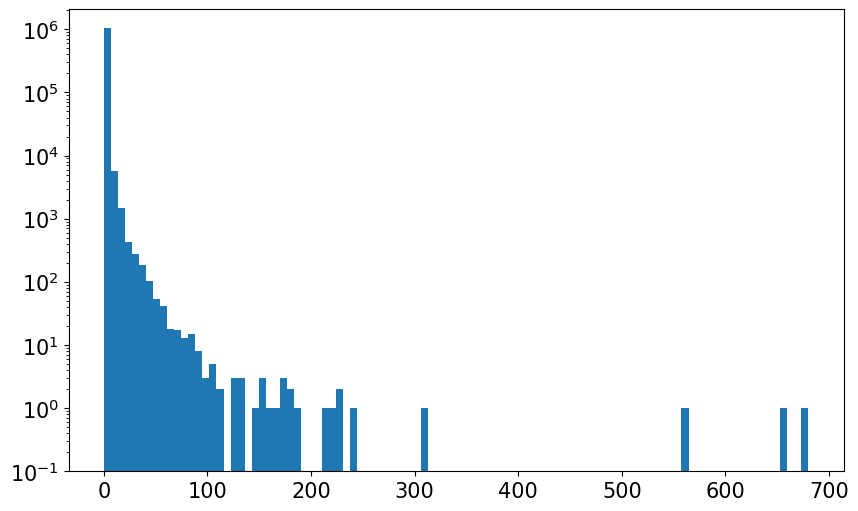

In [82]:
sc1max = int(score1.max())
plt.hist(score1, bins =100, range=(0,sc1max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

In [83]:
sc2max = int(score2.max())
sc2max

671

671


(0.1, 2087572.8434439914)

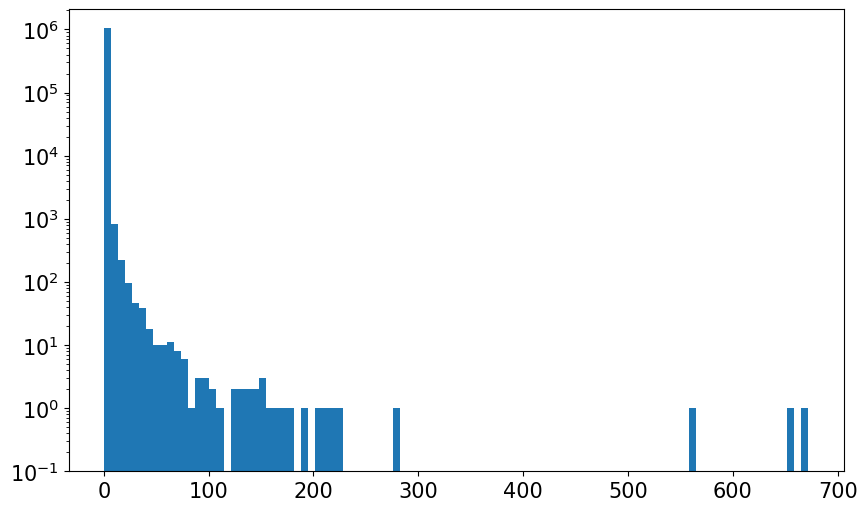

In [84]:
sc2max = int(score2.max())
print(sc2max)
plt.hist(score2, bins =100, range=(0,sc2max+1))
plt.yscale('log')
plt.ylim(ymin=.1)

(array([ 3399.,  4356.,  5726.,  6344.,  7362.,  8724.,  9686., 10224.,
        10076., 10678., 10610., 11326., 11193., 11523., 11502., 11568.,
        11778., 11998., 11869., 11649., 11705., 11871., 11971., 11459.,
        11546., 11448., 11301., 11396., 11284., 11426., 11174., 11473.,
        11301., 11490., 11157., 10892., 10960., 10644., 10554., 10637.,
        10665., 10255., 10336.,  9786., 10046.,  9606., 10230., 12094.,
        11765., 11702., 11688., 11159., 10667., 11206., 10976., 10822.,
        10796., 10565.,  9756.,  9418.,  9949.,  9704.,  9440.,  9459.,
         9754., 10686., 12814., 13437., 12589., 12858., 13108., 13321.,
        13309., 13172., 13859., 12881., 12085., 12019., 11920., 10660.,
        10234.,  9119.,  8360.,  7462.,  7466.,  7507.,  7941.,  8454.,
         9982., 10070., 11209., 10107.,  9737.,  9211.,  8717.,  8235.,
         8265.,  8606.,  7890.,  8930.]),
 array([8.65000000e+01, 1.05390750e+04, 2.09916500e+04, 3.14442250e+04,
        4.18968000e+04

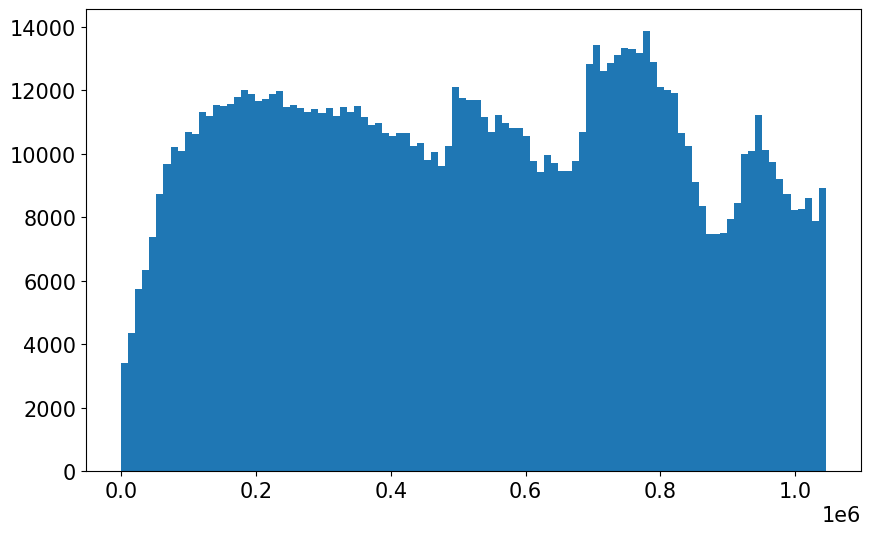

In [85]:
plt.hist(scores['final'],bins=100)

In [86]:
top_records = scores_sorted.head(ntop).index
print(top_records)

Int64Index([ 917942,  956520,  658933, 1059883,  665158,  139726,  333412,
             116647,  684704,  382398,
            ...
              48549,  247382,  684602,  605537, 1065494,  338656,   46696,
              56159,  565280,  565286],
           dtype='int64', name='RECORD', length=10000)


In [87]:
data_zs['RECORD'] = save_record
data_zs.set_index('RECORD', inplace=True, drop=True)
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1inv,...,r1inv_taxclass,r2inv_taxclass,r3inv_taxclass,r4inv_taxclass,r5inv_taxclass,r6inv_taxclass,r7inv_taxclass,r8inv_taxclass,r9inv_taxclass,value_ratio
RECORD,,,,,,,,,,,,,,,,,,,,,
9,0.333647,0.199876,-0.454292,0.757809,0.258843,-0.045178,0.741706,0.302834,-0.039820,-0.091053,...,-0.205326,-0.067048,-0.063599,-0.533203,-0.365550,-0.506182,-0.349374,-0.237411,-0.361787,0.245453
10,0.663433,0.524811,-0.441376,1.162439,0.401072,-0.039350,1.131424,0.461616,-0.030889,-0.091969,...,-0.205744,-0.067134,-0.064432,-0.534102,-0.366006,-0.516906,-0.350163,-0.237762,-0.368182,0.245453
11,1.583414,1.431259,-0.405347,1.231344,0.425293,-0.038357,2.218596,0.904559,-0.005976,-0.092919,...,-0.206178,-0.067224,-0.065297,-0.534202,-0.366057,-0.518108,-0.350982,-0.238126,-0.374827,0.200659
12,-0.217100,-0.342770,-0.475861,0.082072,0.021319,-0.054912,0.090870,0.037666,-0.054735,-0.082441,...,-0.201391,-0.066233,-0.055778,-0.524753,-0.361257,-0.406624,-0.341953,-0.234113,-0.301910,0.245454
13,0.028168,-0.101110,-0.466256,0.383004,0.127098,-0.050577,0.380711,0.155755,-0.048093,-0.088968,...,-0.204373,-0.066851,-0.061702,-0.531156,-0.364510,-0.481855,-0.347577,-0.236612,-0.347241,0.245453


In [88]:
data_zs_top_n = data_zs.loc[top_records]
data_zs_top_n.transpose()

RECORD,917942,956520,658933,1059883,665158,139726,333412,116647,684704,382398,...,48549,247382,684602,605537,1065494,338656,46696,56159,565280,565286
r1,0.765840,-0.115137,0.185038,205.590938,-0.391463,257.090455,-0.395166,163.404917,173.530827,-0.283626,...,4.570563,-0.370832,3.071632,-0.406436,-0.384908,-0.404768,4.702915,5.621359,-0.396429,-0.396429
r2,68.672850,-0.529963,-0.529947,-0.030529,133.808727,-0.030529,-0.529948,4.455811,-0.419599,-0.516333,...,2.651898,0.138878,-0.419599,-0.026476,-0.528803,-0.528621,2.280038,2.593632,-0.216225,-0.216225
r3,45.361579,-0.483278,-0.483267,0.509354,266.503236,0.509354,-0.483268,-0.200193,-0.428449,-0.470368,...,-0.111318,0.846036,-0.428449,0.517410,-0.482708,-0.482617,0.447481,0.292690,0.140299,0.140299
r4,42.629881,-0.051543,0.005343,253.421439,-0.097730,316.814569,-0.112164,148.608755,32.802046,-0.150317,...,4.406438,-0.077923,0.507982,-0.149343,-0.146171,-0.150628,13.879806,10.412410,-0.150704,-0.150704
r5,900.378616,-0.060630,-0.060630,0.158704,163.171486,0.158704,-0.060573,1.554622,-0.053173,-0.060605,...,0.978694,0.420341,-0.053173,0.391245,-0.060540,-0.060540,2.691938,1.892018,-0.056693,-0.056693
r6,614.947517,-0.058268,-0.058267,0.391159,334.407488,0.391159,-0.058229,0.036292,-0.054448,-0.058241,...,0.067000,0.927258,-0.054448,0.867640,-0.058222,-0.058222,0.881742,0.441857,-0.050195,-0.050195
r7,38.312855,-0.087684,-0.040387,252.719895,-0.115181,315.933291,-0.119556,193.448279,11.244027,-0.133428,...,5.748605,-0.090800,0.093863,-0.132875,-0.131997,-0.133535,5.905010,6.990366,-0.132562,-0.132562
r8,937.900247,-0.053824,-0.053823,0.199688,65.591896,0.199688,-0.053801,2.382531,-0.050840,-0.053815,...,1.501035,0.273027,-0.050840,0.192225,-0.053789,-0.053789,1.319322,1.472562,-0.040122,-0.040122
r9,879.198808,-0.059878,-0.059877,0.653070,184.553334,0.653070,-0.059856,0.135882,-0.057781,-0.059864,...,0.197336,0.859318,-0.057781,0.632083,-0.059854,-0.059854,0.583729,0.476696,-0.021341,-0.021341
r1inv,-0.092149,-0.086486,-0.090308,-0.094015,0.046356,-0.094017,0.089743,-0.094012,-0.094013,-0.076202,...,-0.093583,-0.033399,-0.093393,3.006212,0.004974,0.831773,-0.093595,-0.093660,0.111397,0.111397


In [89]:
scores.set_index('RECORD',inplace=True)
scores.drop(columns=['score1','score2'],inplace=True)
scores.head(30)

,score1 rank,score2 rank,final
RECORD,,,
9,851395.0,809542.0,830468.5
10,931285.0,867529.0,899407.0
11,990313.0,931443.0,960878.0
12,740413.0,733712.0,737062.5
13,647905.0,766125.0,707015.0
14,645826.0,764007.0,704916.5
15,973689.0,909785.0,941737.0
16,970857.0,906151.0,938504.0
17,970860.0,906145.0,938502.5


In [90]:
# NY_data_with_scores = NY_data_orig.join(scores, on='RECORD', rsuffix='_scores')
NY_data_with_scores = NY_data_orig.join(scores, on='RECORD')
NY_data_with_scores

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070989,1070990,5080500083,5,8050,83,NaN,"TOBIN, GALE",A1,1,60,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,702050.0,526504.0,614277.0
1070990,1070991,5080500086,5,8050,86,NaN,SHERRI MILINAZZO,A1,1,62,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,984007.0,869626.0,926816.5
1070991,1070992,5080500089,5,8050,89,NaN,JOHN GERVASI,A1,1,53,...,NaN,NaN,NaN,1017.0,FINAL,2010/11,AC-TR,952025.0,931978.0,942001.5
1070992,1070993,5080500092,5,8050,92,NaN,RITA M MOOG,A1,1,52,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,742280.0,726478.0,734379.0


In [91]:
NY_data_scored_and_sorted = NY_data_with_scores.sort_values(by=['final','RECORD'], ascending = [False,True])
NY_data_scored_and_sorted.set_index('RECORD',inplace=True)
NY_data_top_n = NY_data_scored_and_sorted.head(ntop)
NY_data_top_n

,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,LTDEPTH,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
RECORD,,,,,,,,,,,,,,,,,,,,,
917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,0,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1045344.0,1045344.0,1045344.0
956520,5006590012,5,659,12,NaN,TROMPETA RIZALINA,A1,1,25,91,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1045343.0,1045343.0,1045343.0
658933,4029060054,4,2906,54,NaN,WAN CHIU CHEUNG,C0,1,25,100,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1045342.0,1045342.0,1045342.0
1059883,5069770012E,5,6977,12,E,NaN,Z7,4,5,5,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1045341.0,1045341.0,1045341.0
665158,4030720001,4,3072,1,NaN,ST JOHNS CEMETERY,Z8,4,1412,2532,...,1.180764e+07,1.174500e+07,1.180764e+07,NaN,FINAL,2010/11,AC-TR,1045339.0,1045340.0,1045339.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338656,3021360111,3,2136,111,NaN,72 SOUTH 8 STREET LLC,V0,1B,1,80,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1035649.0,1031163.0,1033406.0
46696,1008690074,1,869,74,NaN,NEW YORK PUBLIC LIBRA,P8,4,112,175,...,2.127060e+07,1.708200e+07,2.127060e+07,NaN,FINAL,2010/11,AC-TR,1036545.0,1030256.0,1033400.5
56159,1009970047,1,997,47,NaN,B.K.B.W. REALTY CORP.,H2,4,35,100,...,4.450590e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1034630.0,1032167.0,1033398.5


In [92]:
NY_data_with_scores.head(10)

,RECORD,BBLE,BORO,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,1,1000010101,1,1,101,NaN,U S GOVT LAND & BLDGS,P7,4,500,...,8613000.0,3775500.0,8613000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
1,2,1000010201,1,1,201,NaN,U S GOVT LAND & BLDGS,Z9,4,27,...,80690400.0,11111400.0,80690400.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
2,3,1000020001,1,2,1,NaN,DEPT OF GENERAL SERVI,Y7,4,709,...,40179510.0,32321790.0,40179510.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
3,4,1000020023,1,2,23,NaN,DEPARTMENT OF BUSINES,T2,4,793,...,15750000.0,13644000.0,15750000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
4,5,1000030001,1,3,1,NaN,PARKS AND RECREATION,Q1,4,323,...,107758350.0,106348680.0,107758350.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
5,6,1000030002,1,3,2,NaN,PARKS AND RECREATION,Q1,4,496,...,4268700.0,4268700.0,4268700.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
6,7,1000030003,1,3,3,NaN,PARKS AND RECREATION,Q1,4,180,...,3546900.0,3546900.0,3546900.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
7,8,1000030010,1,3,10,NaN,DEPT RE-CITY OF NY,Z9,4,362,...,11304000.0,9882000.0,11304000.0,NaN,FINAL,2010/11,AC-TR,NaN,NaN,NaN
8,9,1000041001,1,4,1001,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2049290.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,851395.0,809542.0,830468.5
9,10,1000041002,1,4,1002,NaN,"TRZ HOLDINGS, LLC",R5,4,0,...,2961617.0,NaN,NaN,NaN,FINAL,2010/11,AC-TR,931285.0,867529.0,899407.0


In [93]:
NY_data_top_n['OWNER'].head(40)

RECORD
917942      LOGAN PROPERTY, INC.
956520         TROMPETA RIZALINA
658933           WAN CHIU CHEUNG
1059883                      NaN
665158         ST JOHNS CEMETERY
139726     BRADHURST EQUITIES, L
333412            SPOONER ALSTON
116647      MF ASSOCIATES OF NEW
684704                  W RUFERT
382398            MARINO FRANK R
12076      15 WORTH STREET PROPE
252834                       NaN
7054       THE PORT AUTHORITY OF
980276     WOODMONT WEST HOA INC
330291           PRATT INSTITUTE
106681           79TH REALTY LLC
665157         ST JOHNS CEMETERY
982930     FOREST VIEW HOMEOWNER
638993     ALEXANDER'S OF REGOPA
288274                       NaN
1065870    PEOPLE OF THE ST OF N
33564        HLP PROPERTIES, LLC
39770      GREENHORN DEVELOPMENT
330292           PRATT INSTITUTE
610682            DEBORAH WILSON
86946       712 FIFTH AVENUE L P
820884     JAMAICA FIRST PARKING
151044                       NaN
293330      CITY OF NY/PARKS AND
979038           CITY WEST H.O.A
649

In [94]:
NY_data_top_n.shape

(10000, 34)

In [95]:
data_zs_top_n.shape

(10000, 55)

In [96]:
NY_top_with_zs = pd.concat([NY_data_top_n,data_zs_top_n],axis=1)
NY_top_with_zs.shape

(10001, 89)

In [97]:
NY_top_with_zs.to_excel('NY_top_with_zs.xlsx', index=True)
NY_data_top_n.to_excel('NY_top.xlsx', index=True)
data_zs_top_n.to_csv('data_zs_top.csv', index=True)

In [98]:
data_zs_top_n.shape

(10000, 55)

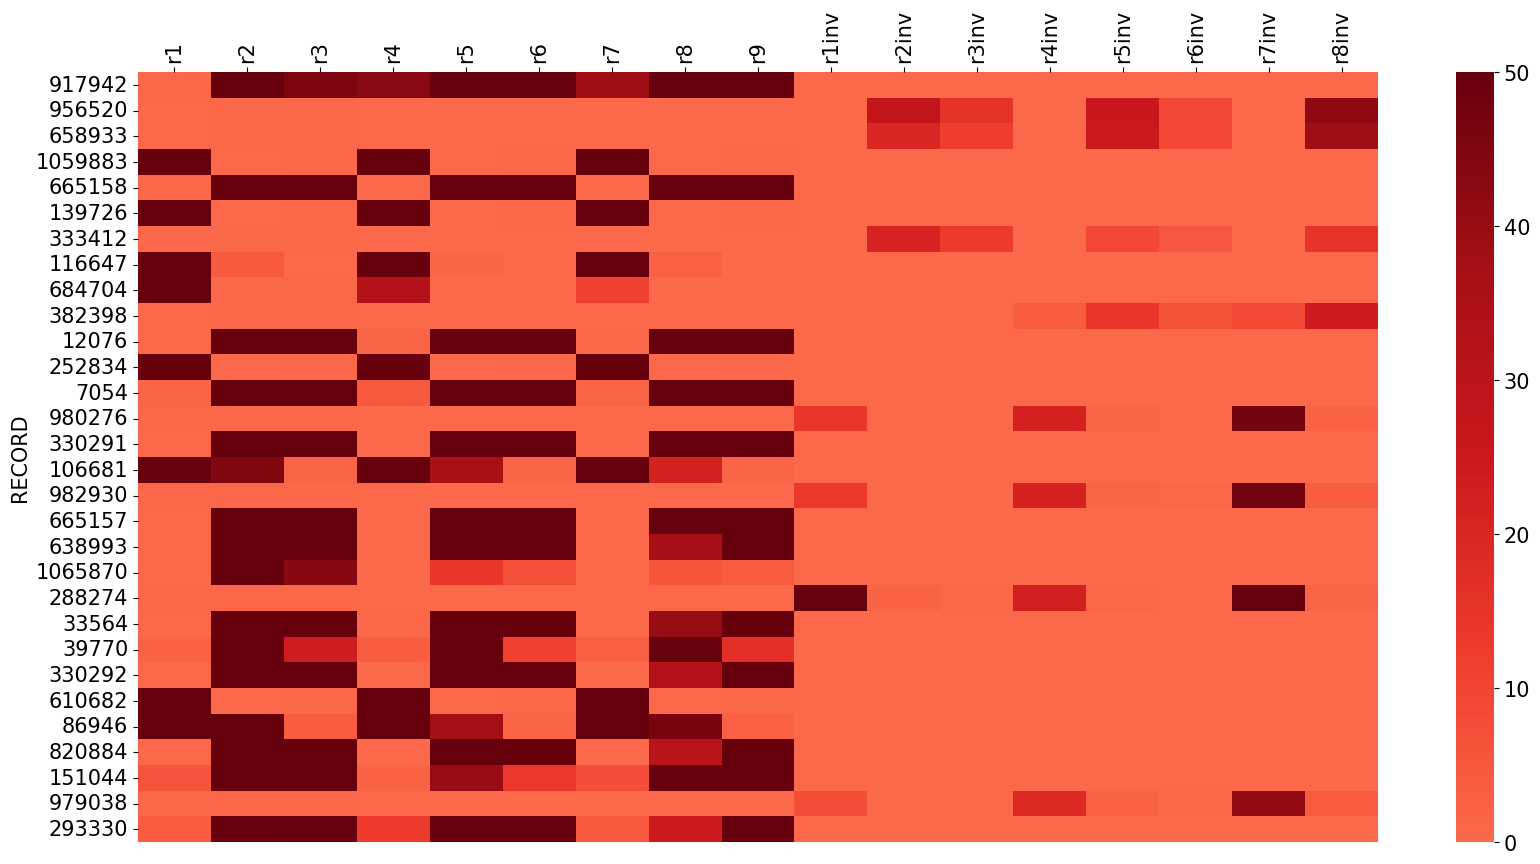

In [99]:
# The heatmaps are good for seeing which variables are driving the high scores
data_base_vars = data_zs_top_n.iloc[:,0:17].abs()
data_heatmap = data_base_vars.head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

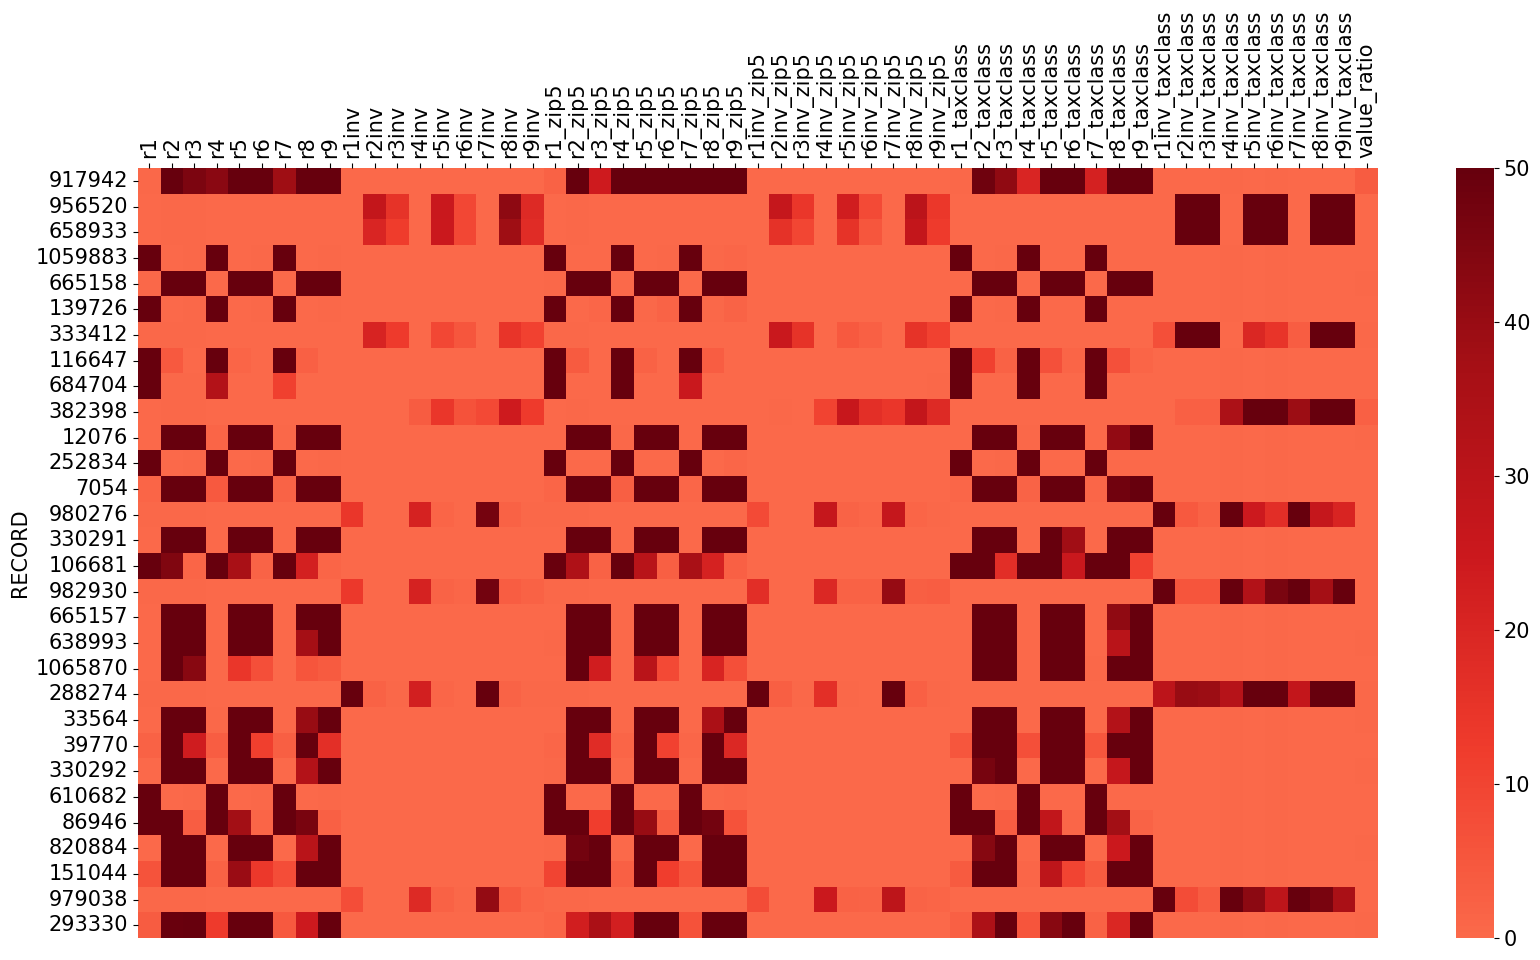

In [100]:
data_zs_top_n_abs = data_zs_top_n.abs()
data_heatmap = data_zs_top_n.abs().head(30)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')

In [101]:
top_records_df = pd.DataFrame(top_records)

In [102]:
# Use this cell if you want to write out the top n record numbers
#top_records_df.to_csv('top_n_record_numbers.csv', index=False)

In [103]:
# # Use this cell if you want to compare to a previous top n record numbers.
# # You can run a baseline model, see which records score the highest, then change some of the algorithm parameters
# # to see what % of these top scoring records change. The top records are insensitive to changes in the 
# # powers for the Minkowski distance measures for the two scores

top_records_previous = pd.read_csv('top_n_record_numbers.csv')
print(top_records_df.head())
print(top_records_previous.head())
num_common = len(pd.merge(top_records_df,top_records_previous, on='RECORD'))
percent_common = 100*num_common/ntop
percent_common

    RECORD
0   917942
1   956520
2   658933
3  1059883
4   665158
    RECORD
0   917942
1   956520
2   658933
3  1059883
4   665158


62.3

In [104]:
# about 4 minutes
print('Duration: ', datetime.now() - start_time)

Duration:  0:01:24.573358
